In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
import itertools
import warnings
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox


In [3]:
# Load data
df = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\AVG_Gas.csv")
# Set datetime as index and assign frequency
# df = df.set_index("Time Period (T)")
# df.index.freq = "MS"  # Assuming monthly data


df["Time Period (T)"] = pd.to_datetime(df["Time Period (T)"], format="%Y-%m-%d")
df = df.sort_values("Time Period (T)").reset_index(drop=True)
display(df.head())

,Time Period (T),Home charging (G),Electric car (G),Hybrid electric (G),Company car tax rate (%),Consumer confidence (E),Economic climate perception (E),Willingness to buy (E),Major purchases sentiment (E),Gasoline (Euro95) - Average price (F),Diesel - Average price (F),Total vehicles sold (Target)
0,2007-01-01,0,1,0,22,20.0,37.0,9.0,8.0,1.303032,0.970000,31
1,2007-02-01,0,0,0,22,20.0,37.0,9.0,8.0,1.325357,0.990000,39
2,2007-03-01,0,0,0,22,20.0,37.0,9.0,8.0,1.379032,1.006323,123
3,2007-04-01,0,0,0,22,20.0,37.0,9.0,8.0,1.426500,1.030600,62
4,2007-05-01,0,2,0,22,18.0,32.0,9.0,7.4,1.466516,1.032323,84


# Data Splitting

In [4]:
# Define forecast horizon (6 months)
forecast_horizon = 6

# Calculate indices for splitting
n_total = len(df)
n_test = forecast_horizon
n_val = forecast_horizon
n_train = n_total - n_val - n_test

# Chronological split
train = df.iloc[:n_train]
val = df.iloc[n_train:n_train + n_val]
test = df.iloc[n_train + n_val:]

print(f"Train: {train.shape}, Validation: {val.shape}, Test: {test.shape}")
print(f"Train ends: {train['Time Period (T)'].iloc[-1]}")
print(f"Validation ends: {val['Time Period (T)'].iloc[-1]}")
print(f"Test ends: {test['Time Period (T)'].iloc[-1]}")

Train: (205, 12), Validation: (6, 12), Test: (6, 12)
Train ends: 2024-01-01 00:00:00
Validation ends: 2024-07-01 00:00:00
Test ends: 2025-01-01 00:00:00


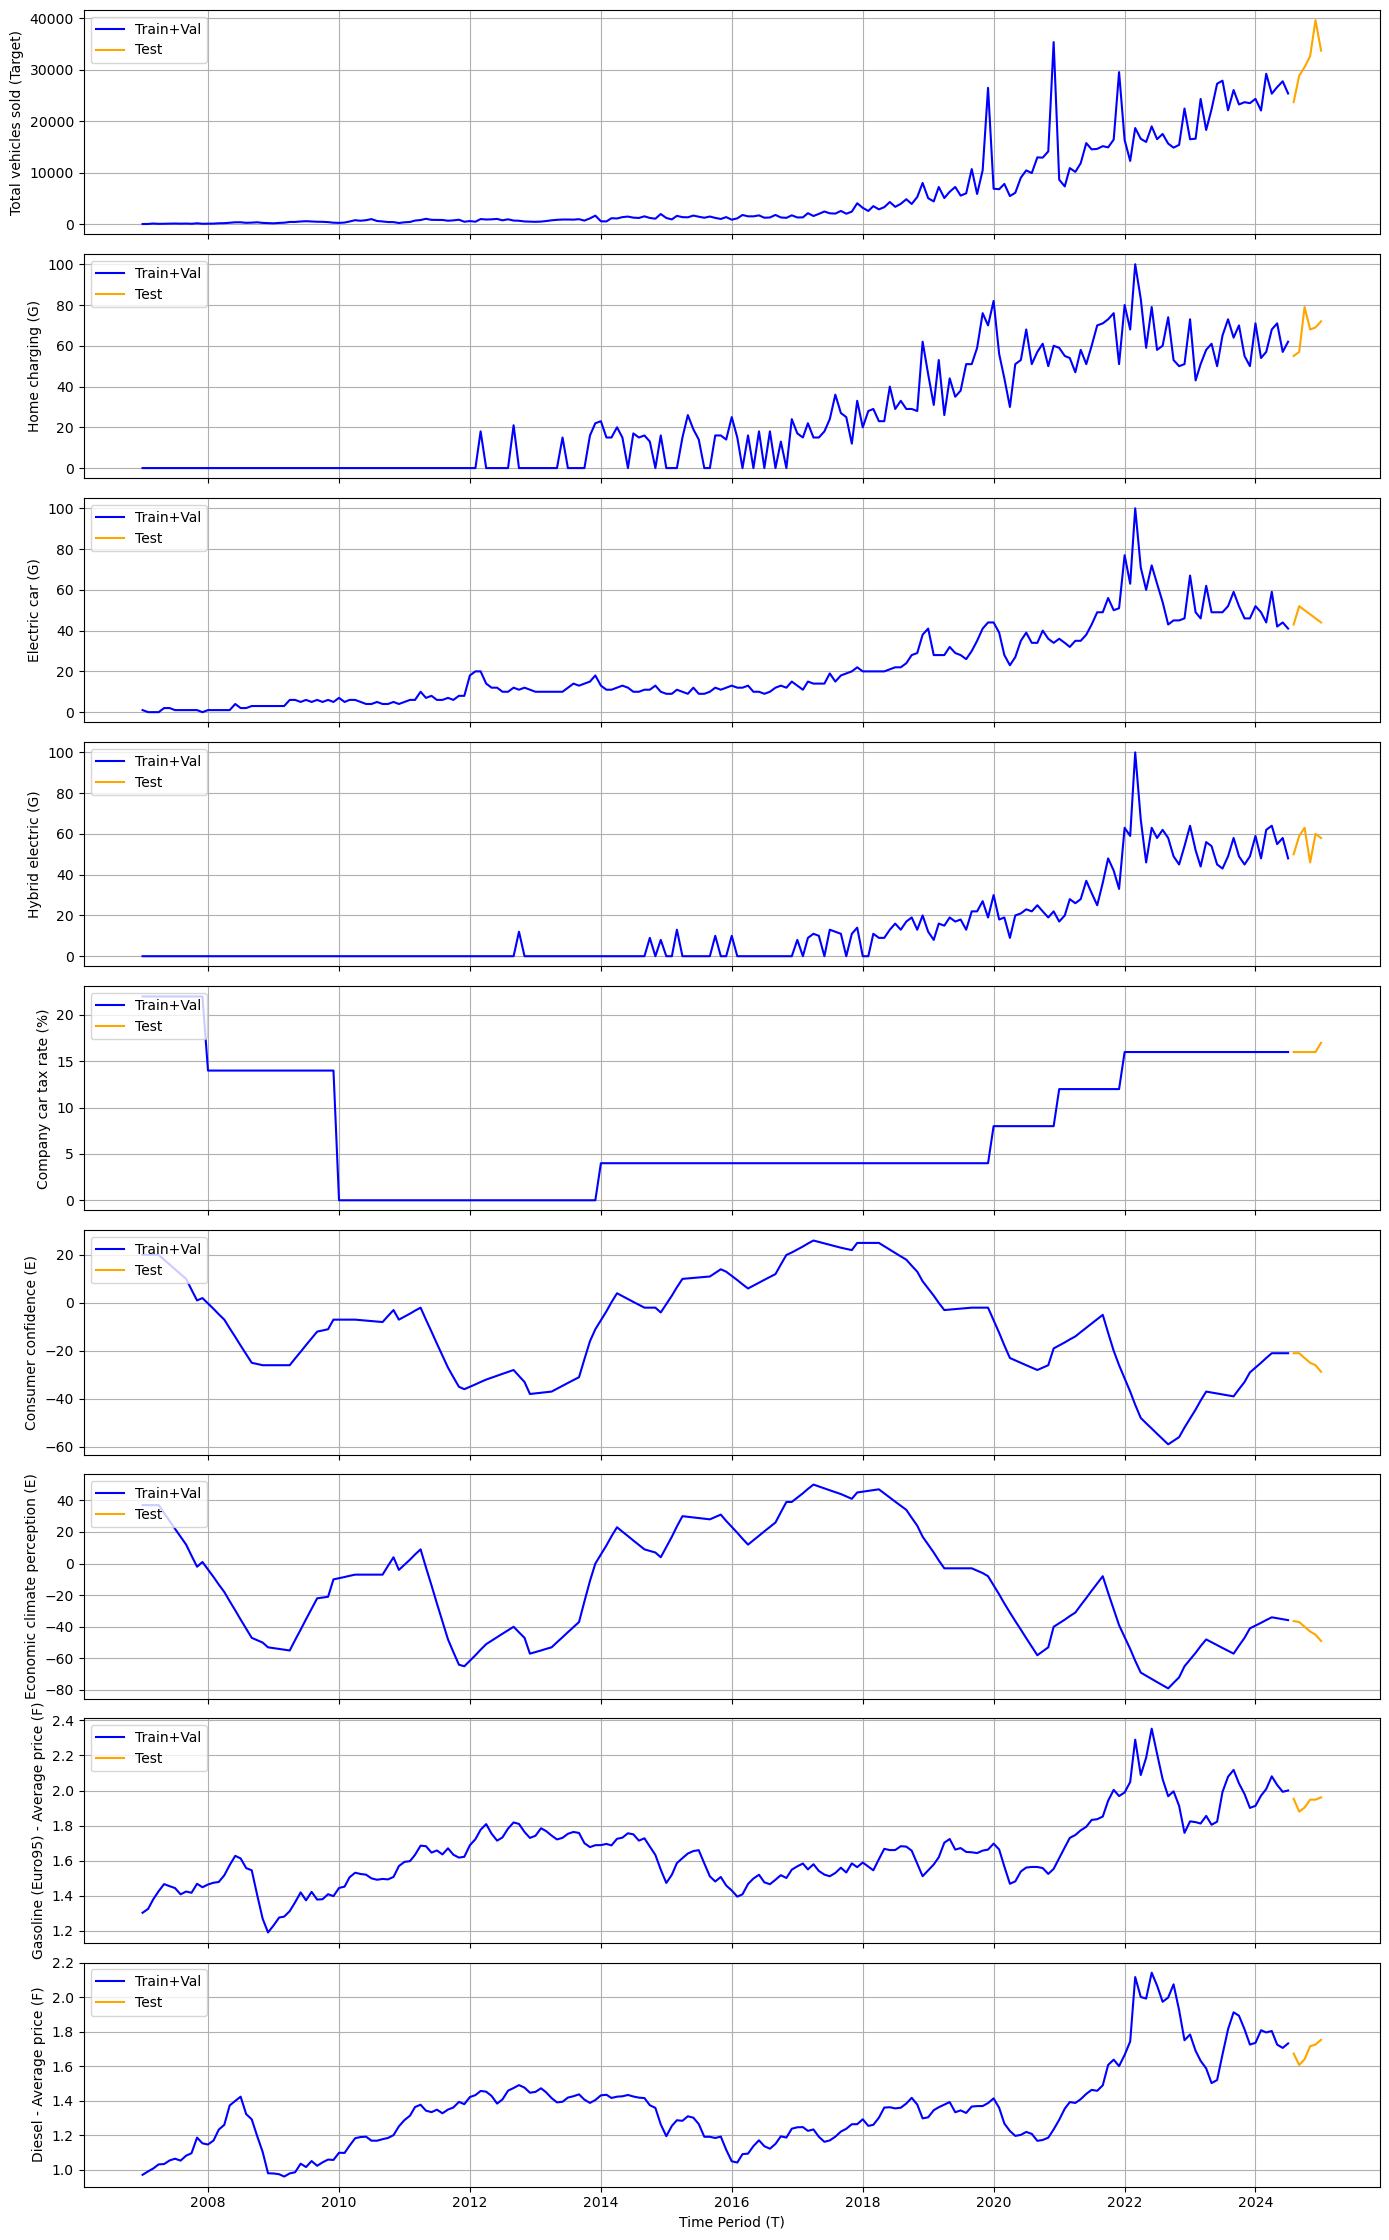

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Columns to plot
cols_to_plot = [
    "Total vehicles sold (Target)",
    "Home charging (G)",
    "Electric car (G)",
    "Hybrid electric (G)",
    "Company car tax rate (%)",
    "Consumer confidence (E)",
    "Economic climate perception (E)",
    "Gasoline (Euro95) - Average price (F)",
    "Diesel - Average price (F)"
]

# Combine train + val
plot_df = pd.concat([train, val])

# Create subplots
fig, axes = plt.subplots(len(cols_to_plot), 1, figsize=(14, 2.5 * len(cols_to_plot)), sharex=True)

# Loop over features
for i, col in enumerate(cols_to_plot):
    axes[i].plot(plot_df["Time Period (T)"], plot_df[col], color='blue', label='Train+Val')
    axes[i].plot(test["Time Period (T)"], test[col], color='orange', label='Test')
    axes[i].set_ylabel(col)
    axes[i].legend(loc='upper left')
    axes[i].grid(True)

# Final styling
axes[-1].set_xlabel("Time Period (T)")
plt.tight_layout()
plt.show()


# Target Transformation

In [6]:
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima.arima.utils import ndiffs

target_col = "Total vehicles sold (Target)"
y = train[target_col]

# Augmented Dickey-Fuller test
adf_result = adfuller(y)
print("ADF Statistic:", adf_result[0])
print("ADF p-value:", adf_result[1])

# KPSS test
kpss_result = kpss(y, regression='c', nlags="auto")
print("KPSS Statistic:", kpss_result[0])
print("KPSS p-value:", kpss_result[1])

# ndiffs (recommended number of differences)
adf_ndiffs = ndiffs(y, test='adf')
kpss_ndiffs = ndiffs(y, test='kpss')
print(f"Recommended differences (ADF): {adf_ndiffs}")
print(f"Recommended differences (KPSS): {kpss_ndiffs}")

# Box-Cox check: must be strictly positive
can_boxcox = (y > 0).all()
print(f"Box-Cox possible: {can_boxcox}")

# Recommendation summary
if adf_result[1] < 0.05 and kpss_result[1] > 0.05:
    print("Series is stationary. No differencing needed.")
else:
    print("Series is likely non-stationary. Differencing recommended.")

if can_boxcox:
    print("Box-Cox transformation is possible (all values positive).")
else:
    print("Box-Cox transformation NOT possible (non-positive values present).")

ADF Statistic: 3.7115296440695733
ADF p-value: 1.0
KPSS Statistic: 1.6286465762306463
KPSS p-value: 0.01
Recommended differences (ADF): 1
Recommended differences (KPSS): 1
Box-Cox possible: True
Series is likely non-stationary. Differencing recommended.
Box-Cox transformation is possible (all values positive).


C:\Users\dylan\AppData\Local\Temp\ipykernel_23228\362897593.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(y, regression='c', nlags="auto")
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was ren

First order difference (train, Box-Cox):


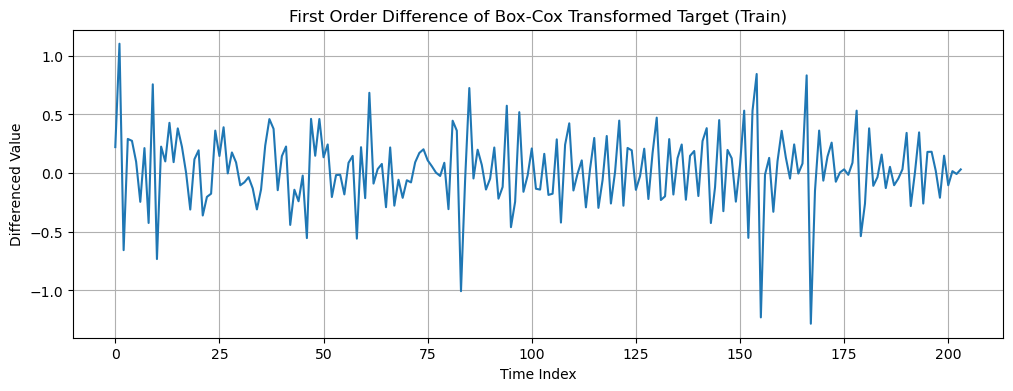

ADF Statistic (diff): -3.9983854257873115
ADF p-value (diff): 0.0014189892740225523
Differenced series is stationary (reject H0).


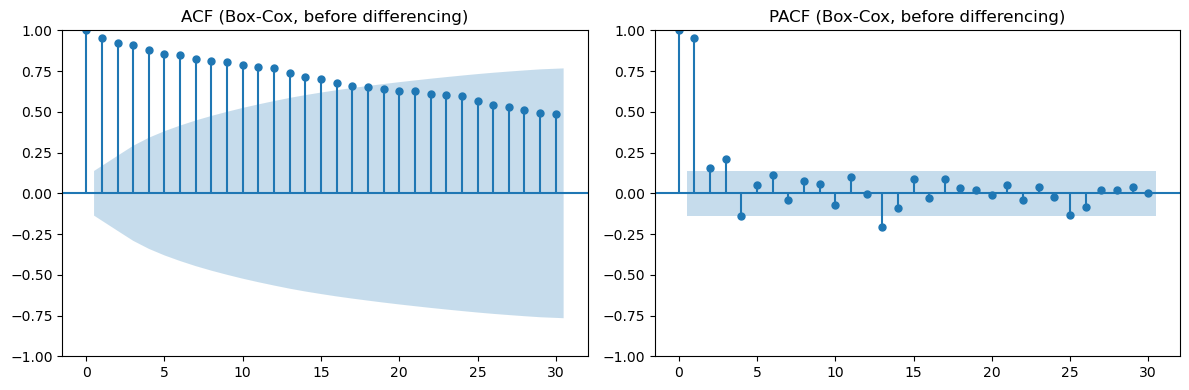

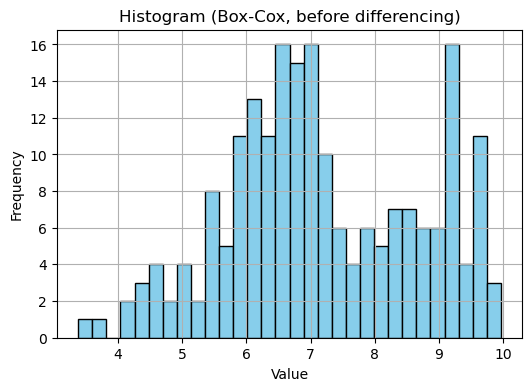

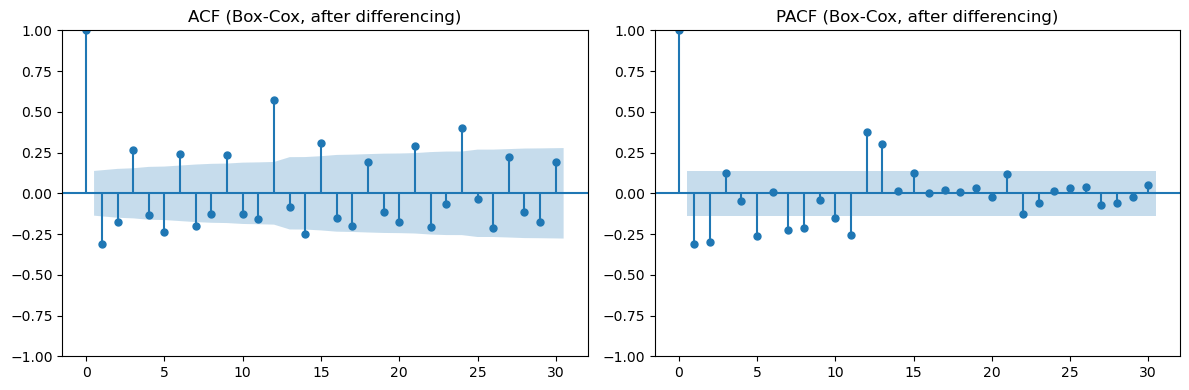

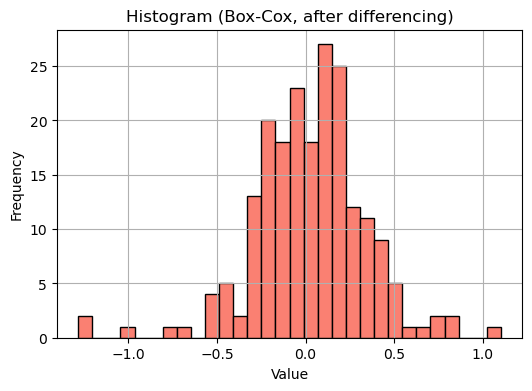

In [17]:
# First order difference of Box-Cox transformed target
y_train_boxcox_diff = np.diff(y_train_boxcox, n=1)

print("First order difference (train, Box-Cox):")

# Plot the first order difference
plt.figure(figsize=(12, 4))
plt.plot(y_train_boxcox_diff)
plt.title("First Order Difference of Box-Cox Transformed Target (Train)")
plt.xlabel("Time Index")
plt.ylabel("Differenced Value")
plt.grid(True)
plt.show()

# ADF test on the differenced series
adf_diff_result = adfuller(y_train_boxcox_diff)
print("ADF Statistic (diff):", adf_diff_result[0])
print("ADF p-value (diff):", adf_diff_result[1])
if adf_diff_result[1] < 0.05:
    print("Differenced series is stationary (reject H0).")
else:
    print("Differenced series is NOT stationary (fail to reject H0).")

# Plot ACF and PACF of Box-Cox transformed target (before differencing)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(y_train_boxcox, lags=30, ax=axes[0])
axes[0].set_title("ACF (Box-Cox, before differencing)")
plot_pacf(y_train_boxcox, lags=30, ax=axes[1])
axes[1].set_title("PACF (Box-Cox, before differencing)")
plt.tight_layout()
plt.show()

# Plot histogram before differencing
plt.figure(figsize=(6, 4))
plt.hist(y_train_boxcox, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram (Box-Cox, before differencing)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot ACF and PACF after differencing
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(y_train_boxcox_diff, lags=30, ax=axes[0])
axes[0].set_title("ACF (Box-Cox, after differencing)")
plot_pacf(y_train_boxcox_diff, lags=30, ax=axes[1])
axes[1].set_title("PACF (Box-Cox, after differencing)")
plt.tight_layout()
plt.show()

# Plot histogram after differencing
plt.figure(figsize=(6, 4))
plt.hist(y_train_boxcox_diff, bins=30, color='salmon', edgecolor='black')
plt.title("Histogram (Box-Cox, after differencing)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)


In [25]:
import pandas as pd

results = []
p_values = range(1, 5)
d_values = [1]  # Usually 1 for most economic time series
q_values = range(1, 5)

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = SARIMAX(
                    y_train_boxcox,
                    order=(p, d, q),
                    seasonal_order=(0, 0, 0, 0),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                result = model.fit(disp=False)
                y_pred_val_boxcox = result.forecast(steps=len(y_val_boxcox))
                y_pred_val = inv_boxcox(y_pred_val_boxcox, lmbda)
                rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
                aic = result.aic
                results.append({'order': (p, d, q), 'AIC': aic, 'RMSE': rmse})
                print(f"Tested order {(p, d, q)}: AIC={aic:.2f}, RMSE={rmse:.2f}")
            except Exception as e:
                print(f"Order {(p, d, q)} failed: {e}")

# Convert results to DataFrame and sort
results_df = pd.DataFrame(results)
print(results_df.sort_values('AIC'))

Tested order (1, 1, 1): AIC=77.59, RMSE=3050.11
Tested order (1, 1, 2): AIC=73.18, RMSE=3059.02
Tested order (1, 1, 3): AIC=72.95, RMSE=3043.00
Tested order (1, 1, 4): AIC=65.72, RMSE=3265.86
Tested order (2, 1, 1): AIC=68.29, RMSE=3005.86
Tested order (2, 1, 2): AIC=61.24, RMSE=2149.96
Tested order (2, 1, 3): AIC=49.94, RMSE=2364.89
Tested order (2, 1, 4): AIC=40.62, RMSE=2288.01
Tested order (3, 1, 1): AIC=69.63, RMSE=2977.53
Tested order (3, 1, 2): AIC=66.62, RMSE=3040.45
Tested order (3, 1, 3): AIC=48.59, RMSE=2394.16
Tested order (3, 1, 4): AIC=44.86, RMSE=2596.14
Tested order (4, 1, 1): AIC=62.21, RMSE=3100.39


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order (4, 1, 2): AIC=60.06, RMSE=2967.35
Tested order (4, 1, 3): AIC=42.39, RMSE=2512.62
Tested order (4, 1, 4): AIC=50.46, RMSE=2353.48
        order        AIC         RMSE
7   (2, 1, 4)  40.624527  2288.013306
14  (4, 1, 3)  42.394337  2512.619608
11  (3, 1, 4)  44.857656  2596.140880
10  (3, 1, 3)  48.590058  2394.161713
6   (2, 1, 3)  49.935000  2364.887450
15  (4, 1, 4)  50.459748  2353.476929
13  (4, 1, 2)  60.063990  2967.353103
5   (2, 1, 2)  61.242435  2149.955211
12  (4, 1, 1)  62.211619  3100.389266
3   (1, 1, 4)  65.720754  3265.862680
9   (3, 1, 2)  66.616943  3040.454258
4   (2, 1, 1)  68.287913  3005.855540
8   (3, 1, 1)  69.627983  2977.532724
2   (1, 1, 3)  72.949231  3042.997132
1   (1, 1, 2)  73.177124  3059.019586
0   (1, 1, 1)  77.587869  3050.111372


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA AIC: 40.62
SARIMA RMSE (val): 2288.01
SARIMA MAPE (val): 0.0826


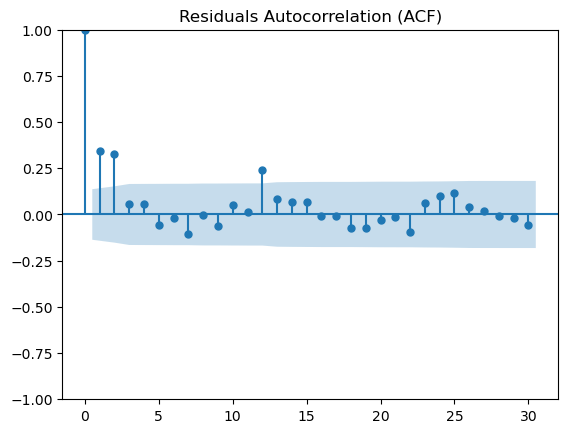

Normality test p-value: 0.0000
Residuals are likely NOT normal.


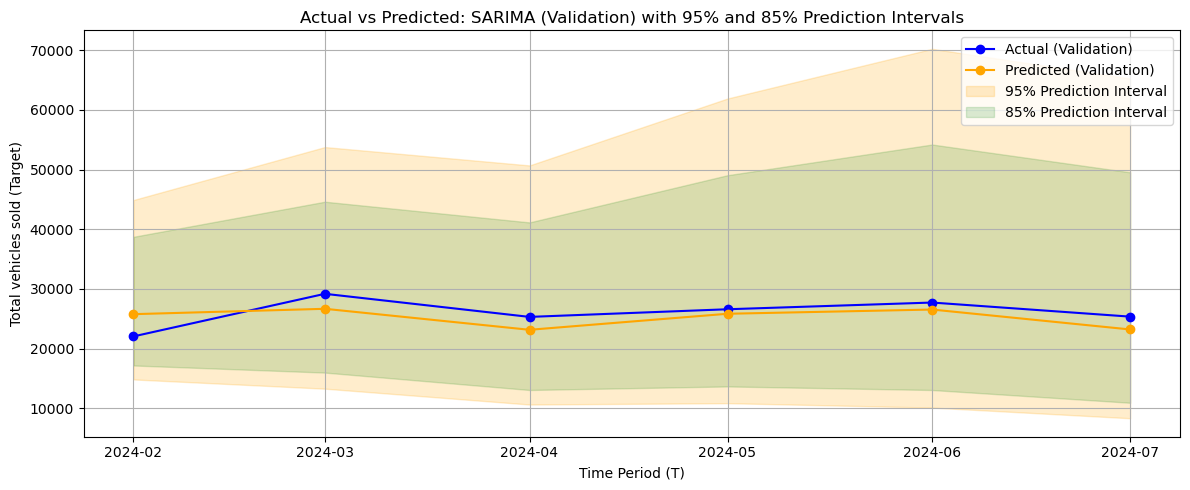

SARIMA RMSE (test): 6859.42
SARIMA MAPE (test): 0.1780


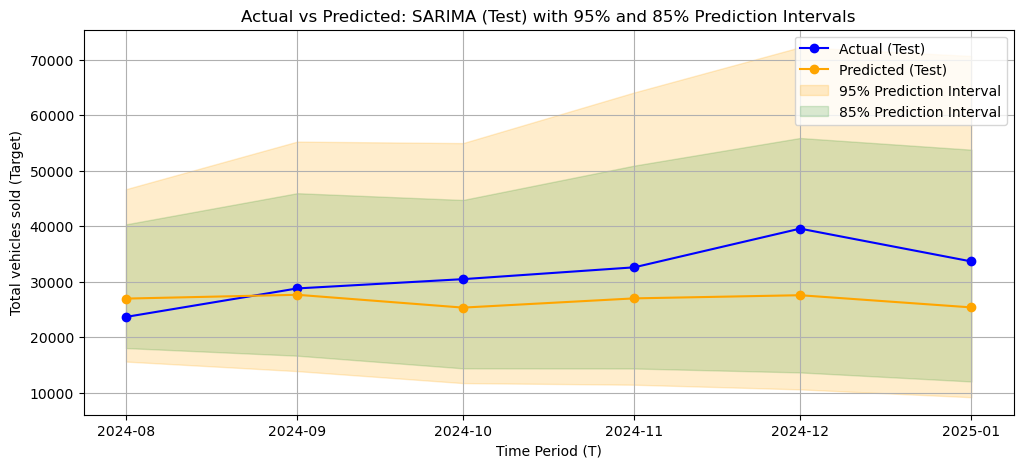

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox, normaltest
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Transform target using Box-Cox (since can_boxcox is True)
y_train = train[target_col].values
y_val = val[target_col].values
y_test = test[target_col].values

y_train_boxcox, lmbda = boxcox(y_train)
y_val_boxcox = boxcox(y_val, lmbda=lmbda)
y_test_boxcox = boxcox(y_test, lmbda=lmbda)

# --- Fit SARIMA on train set, forecast validation ---
sarima_model = SARIMAX(
    y_train_boxcox,
    order=(2, 1, 4),
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_result = sarima_model.fit(disp=False)

y_pred_val_boxcox = sarima_result.forecast(steps=len(y_val_boxcox))
def inv_boxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.power(y * lmbda + 1, 1/lmbda)
y_pred_val = inv_boxcox(y_pred_val_boxcox, lmbda)

rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
mape = mean_absolute_percentage_error(y_val, y_pred_val)
aic = sarima_result.aic

print(f"SARIMA AIC: {aic:.2f}")
print(f"SARIMA RMSE (val): {rmse:.2f}")
print(f"SARIMA MAPE (val): {mape:.4f}")

# Residuals
residuals = sarima_result.resid
plot_acf(residuals, lags=30)
plt.title("Residuals Autocorrelation (ACF)")
plt.show()

stat, p = normaltest(residuals)
print(f"Normality test p-value: {p:.4f}")
if p < 0.05:
    print("Residuals are likely NOT normal.")
else:
    print("Residuals are likely normal.")

# Get SARIMA prediction and confidence interval for validation set
pred_val = sarima_result.get_forecast(steps=len(y_val_boxcox))
pred_val_ci_boxcox = pred_val.conf_int(alpha=0.05)  # 95% CI
pred_val_ci_boxcox_85 = pred_val.conf_int(alpha=0.15)  # 85% CI
ci_lower = inv_boxcox(pred_val_ci_boxcox[:, 0], lmbda)
ci_upper = inv_boxcox(pred_val_ci_boxcox[:, 1], lmbda)
ci_lower_85 = inv_boxcox(pred_val_ci_boxcox_85[:, 0], lmbda)
ci_upper_85 = inv_boxcox(pred_val_ci_boxcox_85[:, 1], lmbda)

plt.figure(figsize=(12, 5))
plt.plot(val["Time Period (T)"], y_val, marker='o', label="Actual (Validation)", color='blue')
plt.plot(val["Time Period (T)"], y_pred_val, marker='o', label="Predicted (Validation)", color='orange')
plt.fill_between(val["Time Period (T)"], ci_lower, ci_upper, color='orange', alpha=0.2, label="95% Prediction Interval")
plt.fill_between(val["Time Period (T)"], ci_lower_85, ci_upper_85, color='green', alpha=0.15, label="85% Prediction Interval")
plt.xlabel("Time Period (T)")
plt.ylabel(target_col)
plt.title("Actual vs Predicted: SARIMA (Validation) with 95% and 85% Prediction Intervals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Retrain SARIMA on train+val, forecast test ---
y_trainval = np.concatenate([y_train, y_val])
y_trainval_boxcox = boxcox(y_trainval, lmbda=lmbda)

sarima_model_tv = SARIMAX(
    y_trainval_boxcox,
    order=(2, 1, 4),
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_result_tv = sarima_model_tv.fit(disp=False)

y_pred_test_boxcox = sarima_result_tv.forecast(steps=len(y_test_boxcox))
y_pred_test = inv_boxcox(y_pred_test_boxcox, lmbda)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
print(f"SARIMA RMSE (test): {rmse_test:.2f}")
print(f"SARIMA MAPE (test): {mape_test:.4f}")

# Get SARIMA prediction and confidence interval for test set
pred_test = sarima_result_tv.get_forecast(steps=len(y_test_boxcox))
pred_test_ci_boxcox = pred_test.conf_int(alpha=0.05)
pred_test_ci_boxcox_85 = pred_test.conf_int(alpha=0.15)
ci_lower_test = inv_boxcox(pred_test_ci_boxcox[:, 0], lmbda)
ci_upper_test = inv_boxcox(pred_test_ci_boxcox[:, 1], lmbda)
ci_lower_test_85 = inv_boxcox(pred_test_ci_boxcox_85[:, 0], lmbda)
ci_upper_test_85 = inv_boxcox(pred_test_ci_boxcox_85[:, 1], lmbda)

plt.figure(figsize=(12, 5))
plt.plot(test["Time Period (T)"], y_test, marker='o', label="Actual (Test)", color='blue')
plt.plot(test["Time Period (T)"], y_pred_test, marker='o', label="Predicted (Test)", color='orange')
plt.fill_between(test["Time Period (T)"], ci_lower_test, ci_upper_test, color='orange', alpha=0.2, label="95% Prediction Interval")
plt.fill_between(test["Time Period (T)"], ci_lower_test_85, ci_upper_test_85, color='green', alpha=0.15, label="85% Prediction Interval")
plt.xlabel("Time Period (T)")
plt.ylabel(target_col)
plt.title("Actual vs Predicted: SARIMA (Test) with 95% and 85% Prediction Intervals")
plt.legend()
plt.grid(True)

## Adding Candidate predictors:
- Fiscal:
    'Company car tax rate (%)'
- google searchterms:
    Home charging (G)', 'Electric car (G)', 'Hybrid electric (G) 
- Consumer confidence:
    'Consumer confidence (E)', 'Economic climate perception (E)', 'Willingness to buy (E)'
Fuel prices:
- 'Diesel price (E)', Gasoline price (E)'


The goal/ workflow will be as followed:
1. Data Cleaning & Transformation --> Apply Box-Cox or log transform
2. Stationarity Check --> ADF + diferencing if needed
3. split data
4. Univariate SARIMAX + Lag Testing Fit SARIMAX using one predictor at a time: 
    Review:

    AIC, AICc, BIC

    Coefficient significance (results.pvalues)

    Residual autocorrelation (Ljung-Box)
    Try lagged exogenous variables to see delayed effets (e.g. search interestc may impact EV sales 1–3 months later).

repeat 1-4 until all candidate predictors are added then select stromngest preficitors 
Track metrics:

RMSE, MAE, MASE on test_df

Residual diagnostics

5. Forecast intervals
6.  Model Evaluation & Logging

# 'Company car tax rate (%)'

### 1. Data Cleaning & Transformation --> Apply Box-Cox or log transform

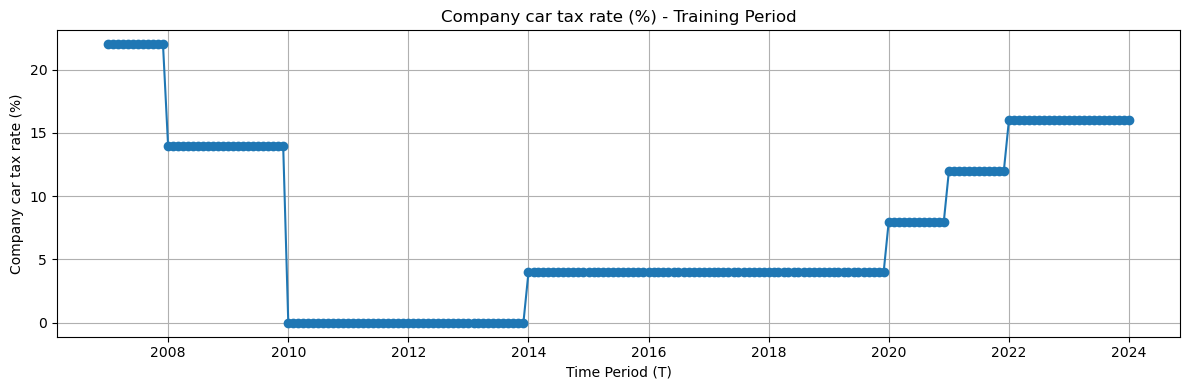

In [18]:
plt.figure(figsize=(12, 4))
plt.plot(train["Time Period (T)"], train["Company car tax rate (%)"], marker='o', color='tab:blue')
plt.title("Company car tax rate (%) - Training Period")
plt.xlabel("Time Period (T)")
plt.ylabel("Company car tax rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Test for Box-Cox Applicability

All values are strictly positive. No shift applied.
Box-Cox lambda: 0.30051626114782465


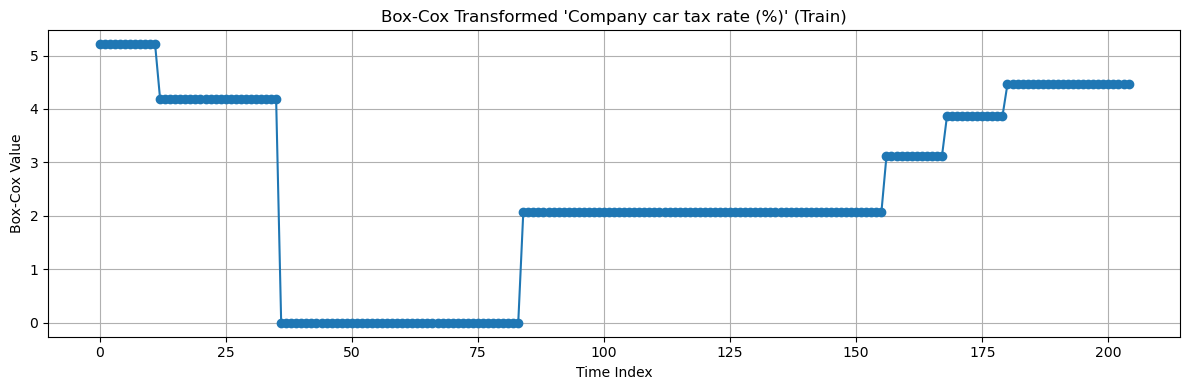

0

In [24]:
from scipy.stats import boxcox

feature = "Company car tax rate (%)"
series = train[feature].values

# Check for non-positive values
if (series <= 0).any():
    min_val = np.min(series)
    shift_value = abs(min_val) + 1
    series_shifted = series + shift_value
    print(f"Non-positive values found. Shift applied: {shift_value}")
else:
    shift_value = 0
    series_shifted = series.copy()
    print("All values are strictly positive. No shift applied.")

# Apply Box-Cox transformation

series_boxcox, lmbda = boxcox(series_shifted)
print(f"Box-Cox lambda: {lmbda}")

# Plot the Box-Cox transformed series
plt.figure(figsize=(12, 4))
plt.plot(series_boxcox, marker='o')
plt.title(f"Box-Cox Transformed '{feature}' (Train)")
plt.xlabel("Time Index")
plt.ylabel("Box-Cox Value")
plt.grid(True)
plt.tight_layout()
plt.show()

# Return shift value for later use
shift_value

### Run Stationarity Tests (ADF + KPSS + ndiffs)

In [25]:
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima.arima.utils import ndiffs

# Use Box-Cox transformed "Company car tax rate (%)" from training period
series_bc = series_boxcox

# ADF test
adf_stat, adf_p, *_ = adfuller(series_bc)
print(f"ADF Statistic: {adf_stat:.4f}")
print(f"ADF p-value: {adf_p:.4f}")

# KPSS test
kpss_stat, kpss_p, *_ = kpss(series_bc, regression='c', nlags="auto")
print(f"KPSS Statistic: {kpss_stat:.4f}")
print(f"KPSS p-value: {kpss_p:.4f}")

# ndiffs recommendations
adf_ndiffs = ndiffs(series_bc, test='adf')
kpss_ndiffs = ndiffs(series_bc, test='kpss')
print(f"Recommended differences (ADF): {adf_ndiffs}")
print(f"Recommended differences (KPSS): {kpss_ndiffs}")

# Interpretation
if adf_p < 0.05 and kpss_p > 0.05:
    print("Interpretation: Series is stationary. No differencing needed.")
else:
    print("Interpretation: Series is likely non-stationary. Differencing recommended.")

ADF Statistic: -1.6780
ADF p-value: 0.4425
KPSS Statistic: 0.4798
KPSS p-value: 0.0462
Recommended differences (ADF): 1
Recommended differences (KPSS): 1
Interpretation: Series is likely non-stationary. Differencing recommended.


c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\d

### Apply First/Second Differencing

c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\d

Recommended differencing order: 1
ADF Statistic (diff): -3.9984, p-value: 0.0014
KPSS Statistic (diff): 0.0795, p-value: 0.1000
Differenced series is stationary.


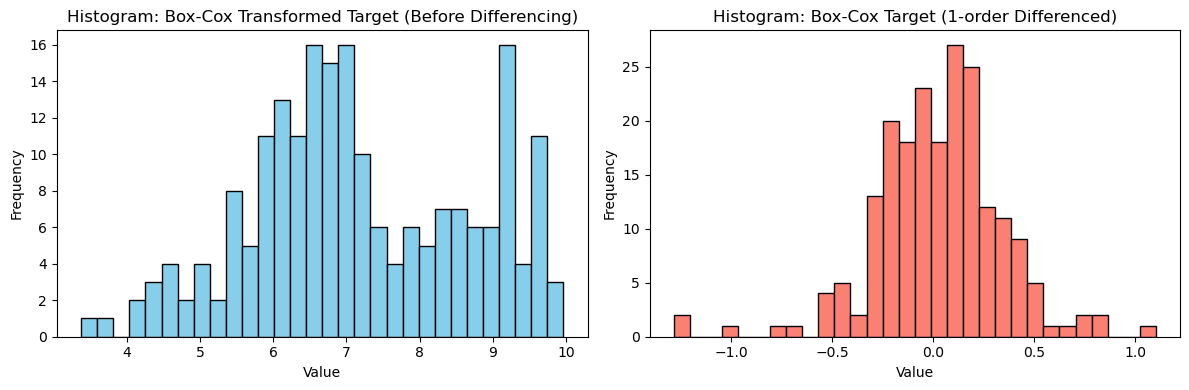

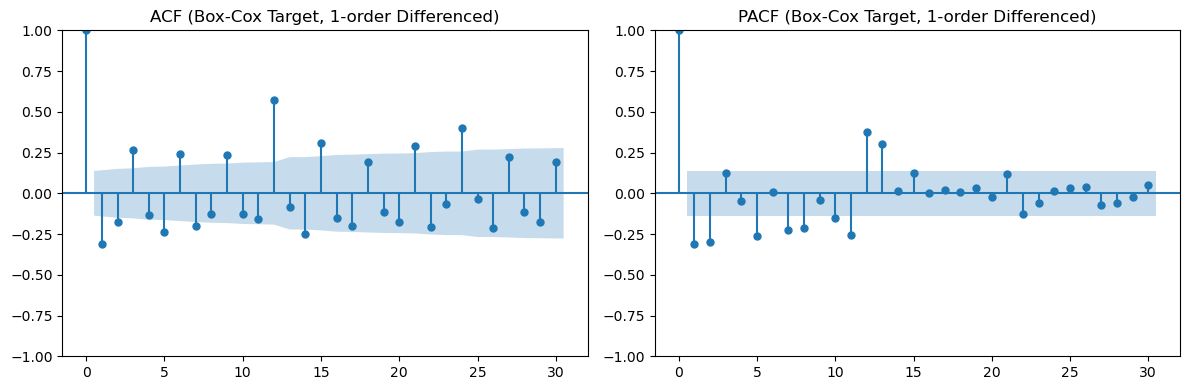

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Use Box-Cox transformed target from training set
series_bc = y_train_boxcox

# Determine differencing order (from previous ndiffs or cell 20)
adf_ndiffs = ndiffs(series_bc, test='adf')
kpss_ndiffs = ndiffs(series_bc, test='kpss')
diff_order = max(adf_ndiffs, kpss_ndiffs, 1)  # At least 1

print(f"Recommended differencing order: {diff_order}")

# Apply differencing
if diff_order == 1:
    series_bc_diff = np.diff(series_bc, n=1)
elif diff_order == 2:
    series_bc_diff = np.diff(series_bc, n=2)
else:
    series_bc_diff = series_bc.copy()

# Confirm stationarity after differencing
adf_stat, adf_p, *_ = adfuller(series_bc_diff)
kpss_stat, kpss_p, *_ = kpss(series_bc_diff, regression='c', nlags="auto")
print(f"ADF Statistic (diff): {adf_stat:.4f}, p-value: {adf_p:.4f}")
print(f"KPSS Statistic (diff): {kpss_stat:.4f}, p-value: {kpss_p:.4f}")
if adf_p < 0.05 and kpss_p > 0.05:
    print("Differenced series is stationary.")
else:
    print("Differenced series is still non-stationary.")

# Plot histograms before and after differencing
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(series_bc, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram: Box-Cox Transformed Target (Before Differencing)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.subplot(1, 2, 2)
plt.hist(series_bc_diff, bins=30, color='salmon', edgecolor='black')
plt.title(f"Histogram: Box-Cox Target ({diff_order}-order Differenced)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Plot ACF and PACF after differencing
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(series_bc_diff, lags=30, ax=axes[0])
axes[0].set_title(f"ACF (Box-Cox Target, {diff_order}-order Differenced)")
plot_pacf(series_bc_diff, lags=30, ax=axes[1])
axes[1].set_title(f"PACF (Box-Cox Target, {diff_order}-order Differenced)")
plt.tight_layout()
plt.show()

### Evaluate SARIMAX with This Company Car Tax Rate


SARIMAX (with exog) AIC: 34.44
SARIMAX (with exog) RMSE (val): 22969.75
SARIMAX (with exog) MAPE (val): 0.8771
Coefficient p-values:
[0.35817495 0.         0.         0.92457167 0.95797144 0.94874732
 0.95293455 0.94758072]
Normality test p-value: 0.0000
Residuals are likely NOT normal.


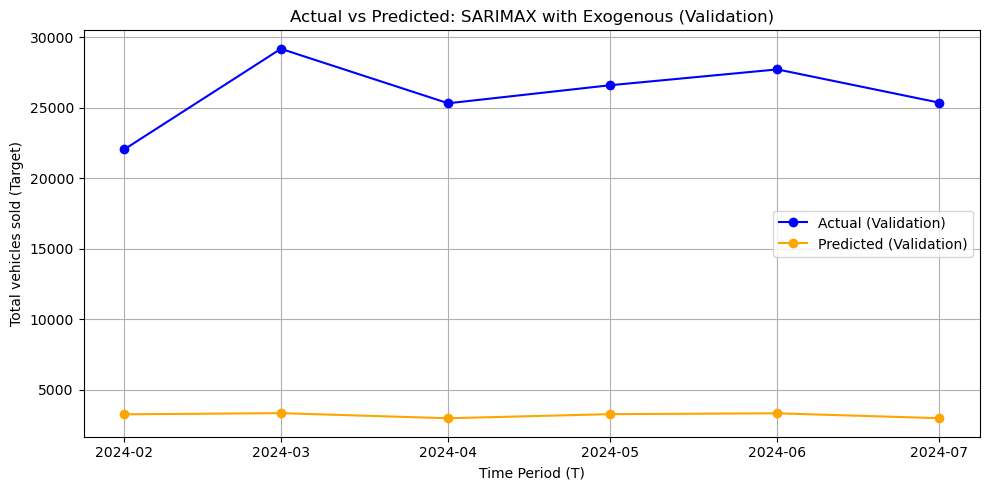

Backtransformed RMSE (val): 22969.75
Backtransformed MAPE (val): 0.8771
Leaderboard so far:
Company car tax rate (%): {'AIC': 34.43608602735942, 'RMSE_val': 22969.745616693515, 'MAPE_val': 0.8770652569916245}


In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import normaltest

# Use Box-Cox transformed target and exogenous feature
lag = 1
exog_train = np.roll(series_boxcox, lag)
exog_val = np.roll(val["Company car tax rate (%)"].values, lag)

# Align train (remove first lagged value)
y_train_bc = y_train_boxcox[lag:]
exog_train_lag = exog_train[lag:]

# For validation, use Box-Cox transform and same lambda/shift as train
val_exog_shifted = val["Company car tax rate (%)"].values + shift_value
val_exog_boxcox = boxcox(val_exog_shifted, lmbda=lmbda)
exog_val_lag = val_exog_boxcox

# Fit SARIMAX with exogenous
model = SARIMAX(
    y_train_bc,
    exog=exog_train_lag.reshape(-1, 1),
    order=(2, 1, 4),
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
result = model.fit(disp=False)

# Forecast validation
y_pred_val_boxcox = result.forecast(steps=len(exog_val_lag), exog=exog_val_lag.reshape(-1, 1))
y_pred_val = inv_boxcox(y_pred_val_boxcox, lmbda)

# Evaluate metrics
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
mape = mean_absolute_percentage_error(y_val, y_pred_val)
aic = result.aic

print(f"SARIMAX (with exog) AIC: {aic:.2f}")
print(f"SARIMAX (with exog) RMSE (val): {rmse:.2f}")
print(f"SARIMAX (with exog) MAPE (val): {mape:.4f}")

# Coefficient p-values
print("Coefficient p-values:")
print(result.pvalues)

# Residual normality test
stat, p = normaltest(result.resid)
print(f"Normality test p-value: {p:.4f}")
if p < 0.05:
    print("Residuals are likely NOT normal.")
else:
    print("Residuals are likely normal.")

# Plot actual vs predicted for validation set
plt.figure(figsize=(10, 5))
plt.plot(val["Time Period (T)"], y_val, marker='o', label="Actual (Validation)", color='blue')
plt.plot(val["Time Period (T)"], y_pred_val, marker='o', label="Predicted (Validation)", color='orange')
plt.xlabel("Time Period (T)")
plt.ylabel(target_col)
plt.title("Actual vs Predicted: SARIMAX with Exogenous (Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print backtransformed RMSE and MAPE
print(f"Backtransformed RMSE (val): {rmse:.2f}")
print(f"Backtransformed MAPE (val): {mape:.4f}")

# Store results in a leaderboard dictionary for comparison
if 'leaderboard' not in globals():
    leaderboard = {}

feature_name = "Company car tax rate (%)"
leaderboard[feature_name] = {
    "AIC": aic,
    "RMSE_val": rmse,
    "MAPE_val": mape
}

print("Leaderboard so far:")
for k, v in leaderboard.items():
    print(f"{k}: {v}")


c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\d

Recommended differencing order: 1


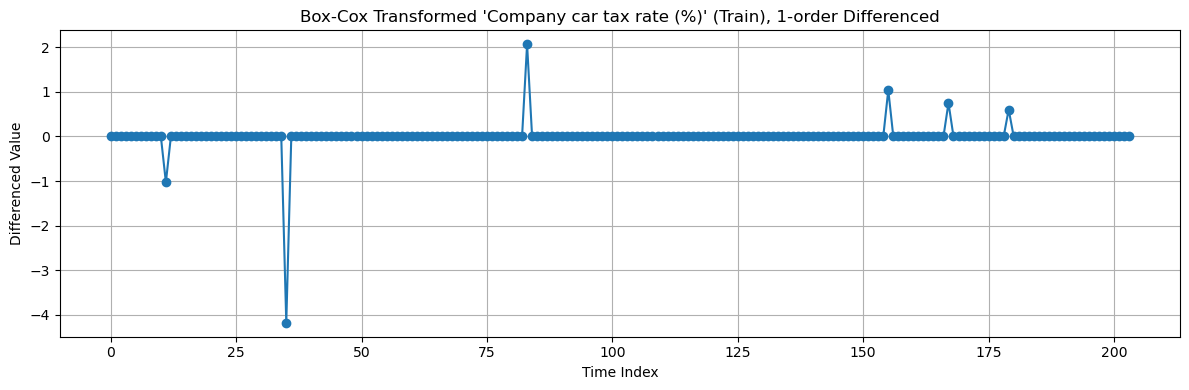

ADF Statistic (diff): -14.1790, p-value: 0.0000
KPSS Statistic (diff): 0.3513, p-value: 0.0982
Differenced series is stationary.


In [26]:
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima.arima.utils import ndiffs

# Determine differencing order from previous ndiffs results (cell 17)

# Use Box-Cox transformed series from training period
series_bc = series_boxcox

# Determine recommended differencing order
adf_ndiffs = ndiffs(series_bc, test='adf')
kpss_ndiffs = ndiffs(series_bc, test='kpss')
diff_order = max(adf_ndiffs, kpss_ndiffs, 1)  # At least 1

print(f"Recommended differencing order: {diff_order}")

# Apply differencing
if diff_order == 1:
    series_bc_diff = np.diff(series_bc, n=1)
elif diff_order == 2:
    series_bc_diff = np.diff(series_bc, n=2)
else:
    series_bc_diff = series_bc.copy()

# Plot the differenced series
plt.figure(figsize=(12, 4))
plt.plot(series_bc_diff, marker='o')
plt.title(f"Box-Cox Transformed '{feature}' (Train), {diff_order}-order Differenced")
plt.xlabel("Time Index")
plt.ylabel("Differenced Value")
plt.grid(True)
plt.tight_layout()
plt.show()

# Stationarity tests on differenced series
adf_stat, adf_p, *_ = adfuller(series_bc_diff)
kpss_stat, kpss_p, *_ = kpss(series_bc_diff, regression='c', nlags="auto")
print(f"ADF Statistic (diff): {adf_stat:.4f}, p-value: {adf_p:.4f}")
print(f"KPSS Statistic (diff): {kpss_stat:.4f}, p-value: {kpss_p:.4f}")

if adf_p < 0.05 and kpss_p > 0.05:
    print("Differenced series is stationary.")
else:
    print("Differenced series is still non-stationary.")

In [12]:
from statsmodels.tsa.stattools import adfuller

exog_features = [
    "Home charging (G)",
    "Electric car (G)",
    "Hybrid electric (G)",
    "Company car tax rate (%)",
    "Consumer confidence (E)",
    "Economic climate perception (E)",
    "Gasoline (Euro95) - Average price (F)",
    "Diesel - Average price (F)"
]

stationarity_results = []

for col in exog_features:
    series = train[col].values
    adf_stat, adf_p, *_ = adfuller(series)
    if adf_p < 0.05:
        status = "Stationary (no differencing needed)"
    else:
        status = "Non-stationary (differencing recommended)"
    stationarity_results.append({
        "feature": col,
        "adf_stat": adf_stat,
        "adf_pvalue": adf_p,
        "stationarity": status
    })

results_df = pd.DataFrame(stationarity_results)
display(results_df[["feature", "adf_stat", "adf_pvalue", "stationarity"]])

,feature,adf_stat,adf_pvalue,stationarity
0,Home charging (G),-0.363008,0.916094,Non-stationary (differencing recommended)
1,Electric car (G),-0.505484,0.890942,Non-stationary (differencing recommended)
2,Hybrid electric (G),0.213252,0.972995,Non-stationary (differencing recommended)
3,Company car tax rate (%),-1.934891,0.315830,Non-stationary (differencing recommended)
4,Consumer confidence (E),-2.520177,0.110642,Non-stationary (differencing recommended)
5,Economic climate perception (E),-2.158835,0.221524,Non-stationary (differencing recommended)
6,Gasoline (Euro95) - Average price (F),-2.448358,0.128550,Non-stationary (differencing recommended)
7,Diesel - Average price (F),-1.978989,0.295861,Non-stationary (differencing recommended)


In [ ]:
# Get non-stationary features from results_df
non_stationary_features = results_df.loc[
    results_df['stationarity'] == 'Non-stationary (differencing recommended)', 'feature'
].tolist()

# Apply first difference to each non-stationary feature in the training set
diffed_features = {}
for col in non_stationary_features:
    # First difference, align so that the first value is NaN (to avoid lookahead leakage)
    diffed = train[col].diff().reset_index(drop=True)
    diffed_features[col + '_diff1'] = diffed

# Combine into a DataFrame for modeling (dropping the first row due to NaN)
diffed_df = pd.DataFrame(diffed_features).iloc[1:].reset_index(drop=True)

display(diffed_df.head())




,Home charging (G)_diff1,Electric car (G)_diff1,Hybrid electric (G)_diff1,Company car tax rate (%)_diff1,Consumer confidence (E)_diff1,Economic climate perception (E)_diff1,Gasoline (Euro95) - Average price (F)_diff1,Diesel - Average price (F)_diff1
0,0.0,-1.0,0.0,0.0,0.0,0.0,0.022325,0.020000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.053675,0.016323
2,0.0,0.0,0.0,0.0,0.0,0.0,0.047468,0.024277
3,0.0,2.0,0.0,0.0,-2.0,-5.0,0.040016,0.001723
4,0.0,0.0,0.0,0.0,-2.0,-5.0,-0.011916,0.021111


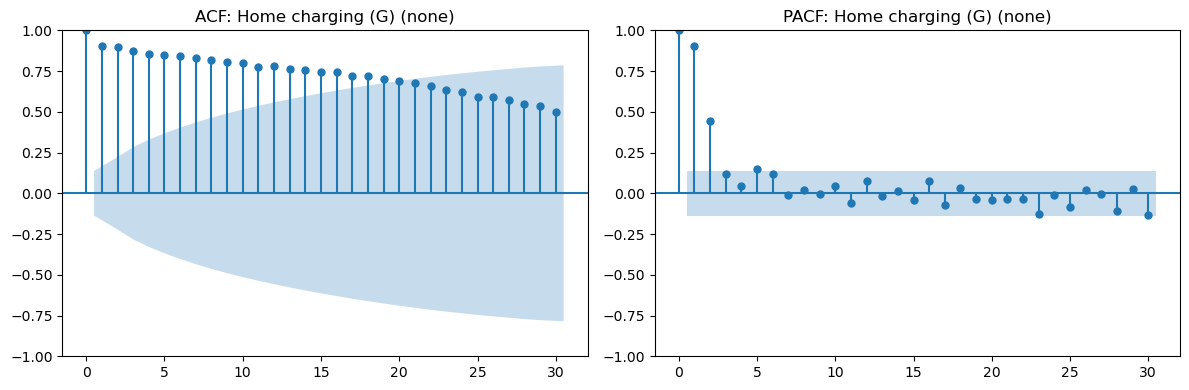

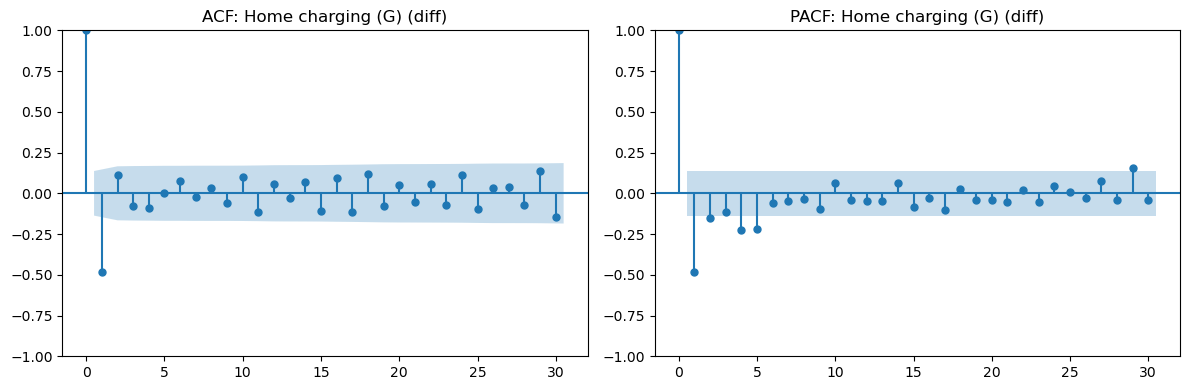

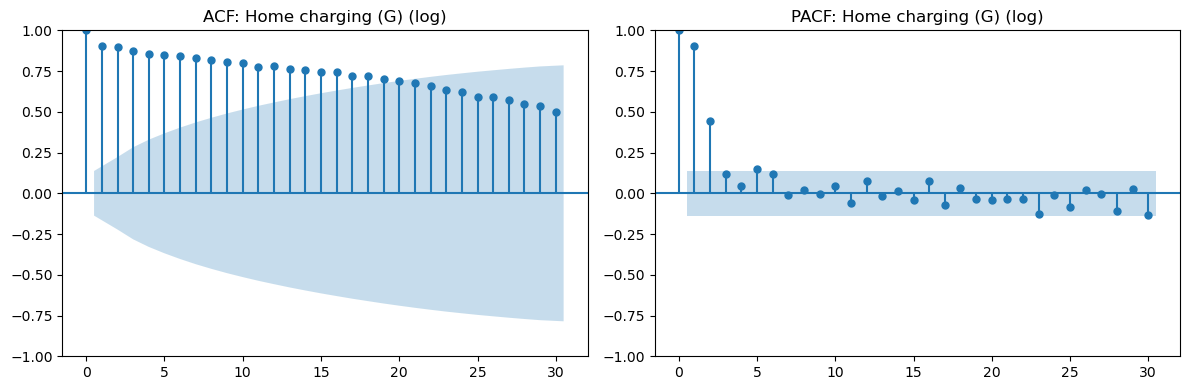

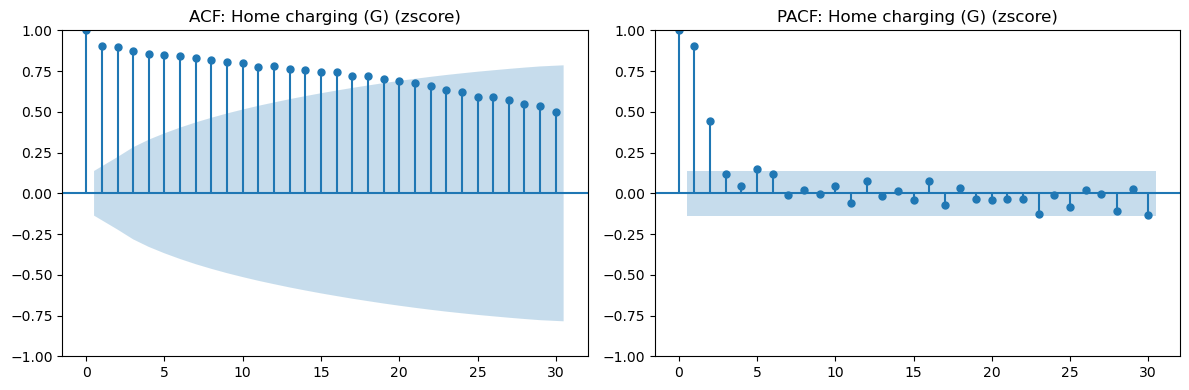

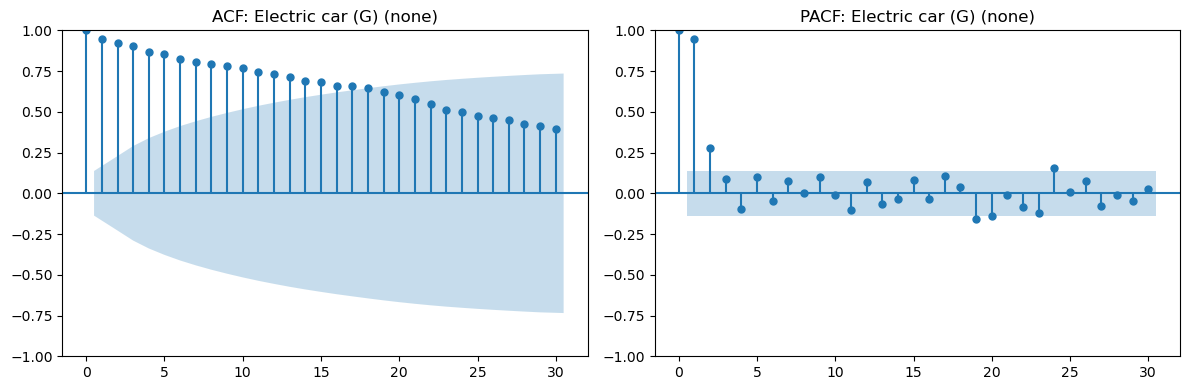

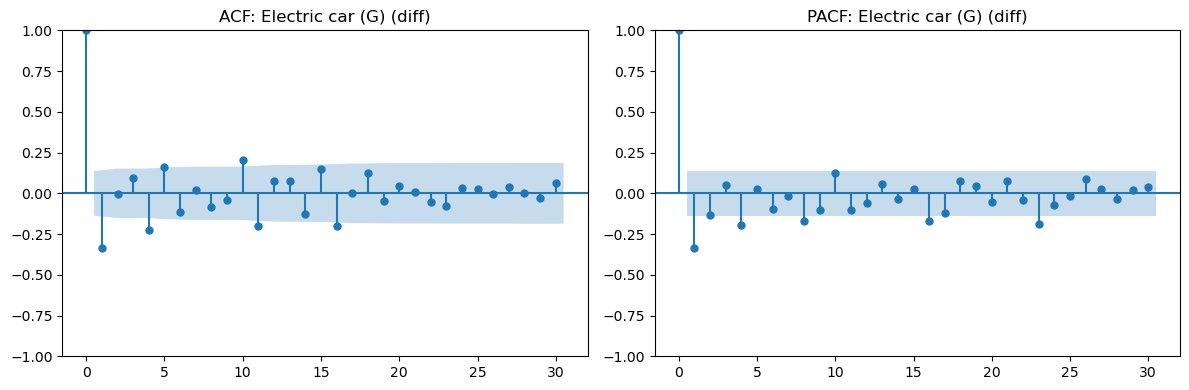

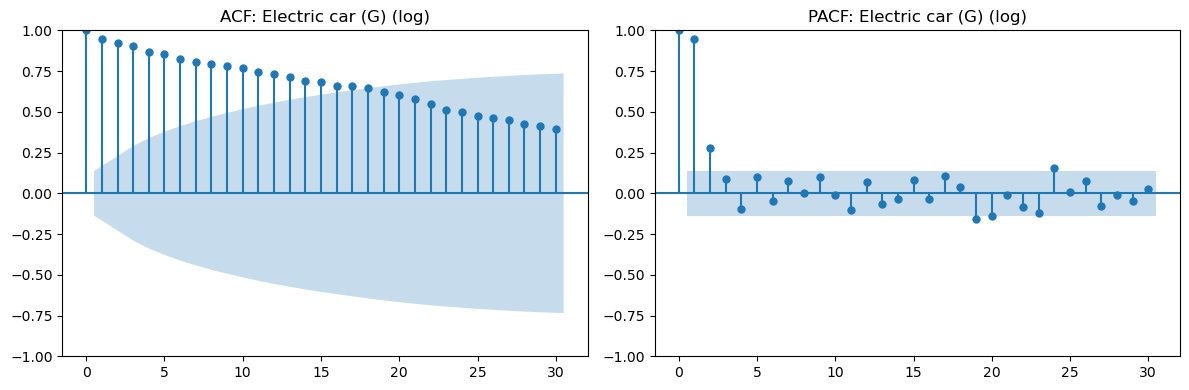

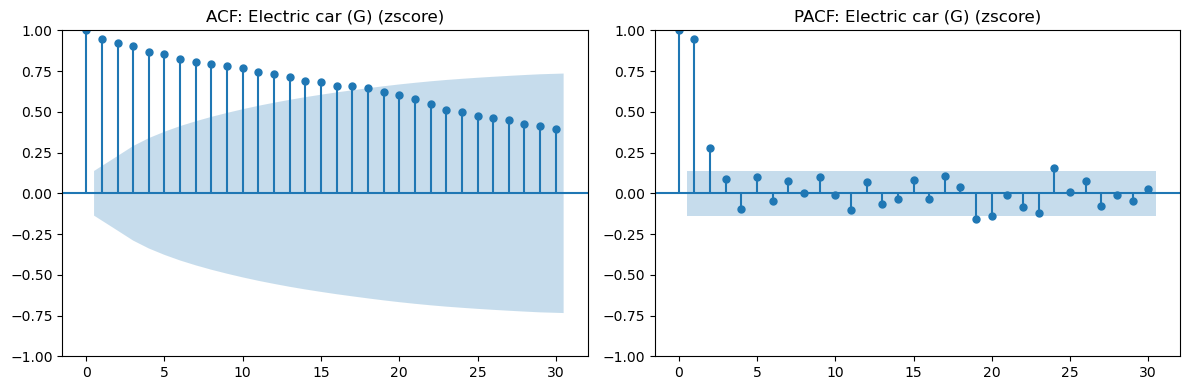

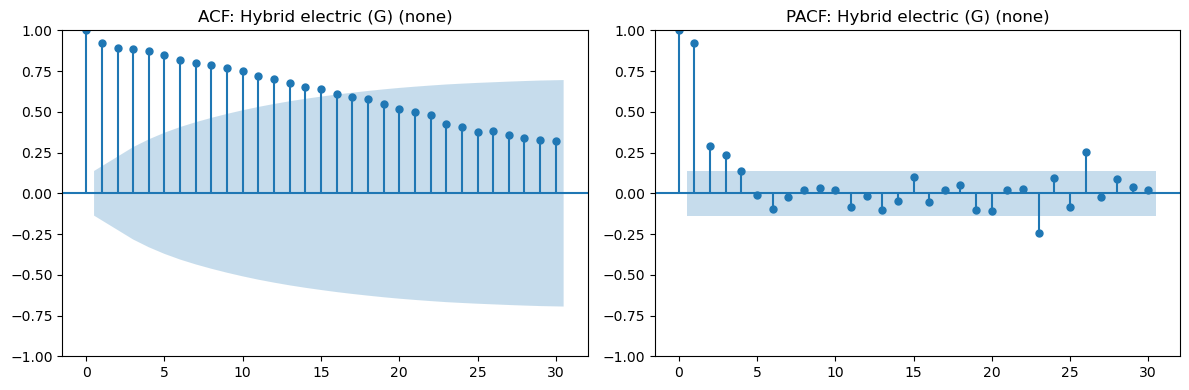

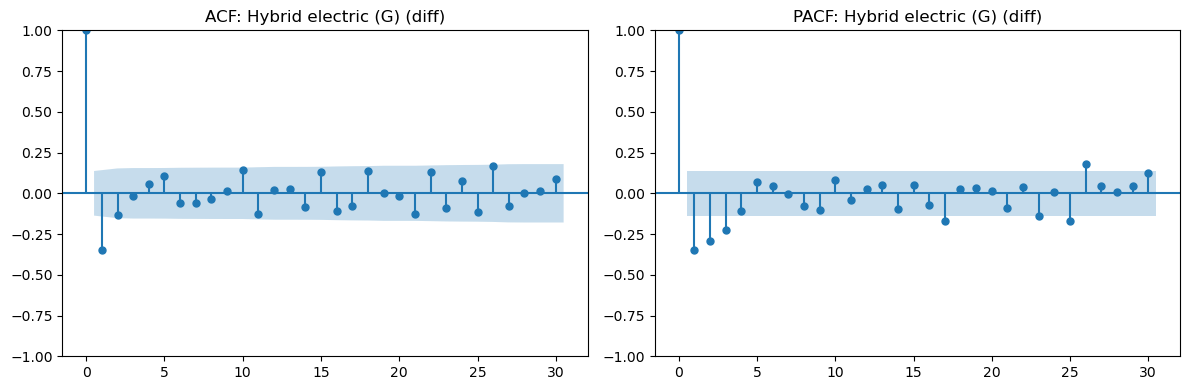

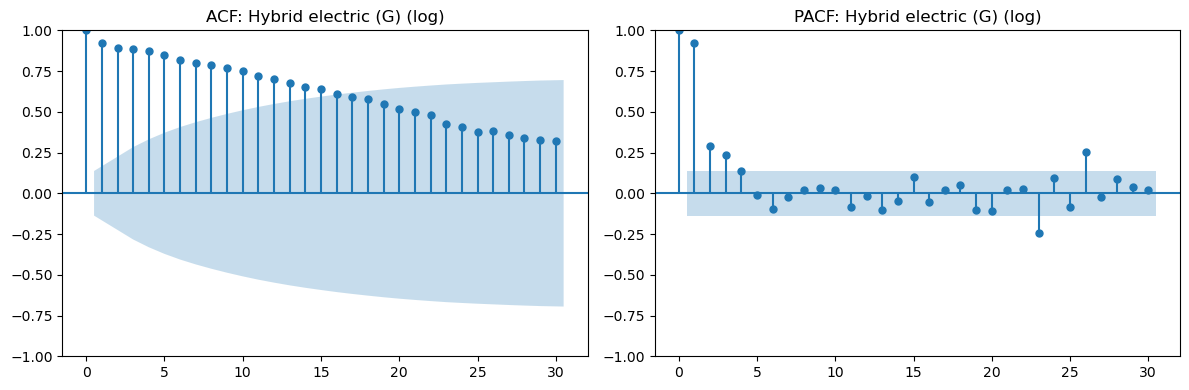

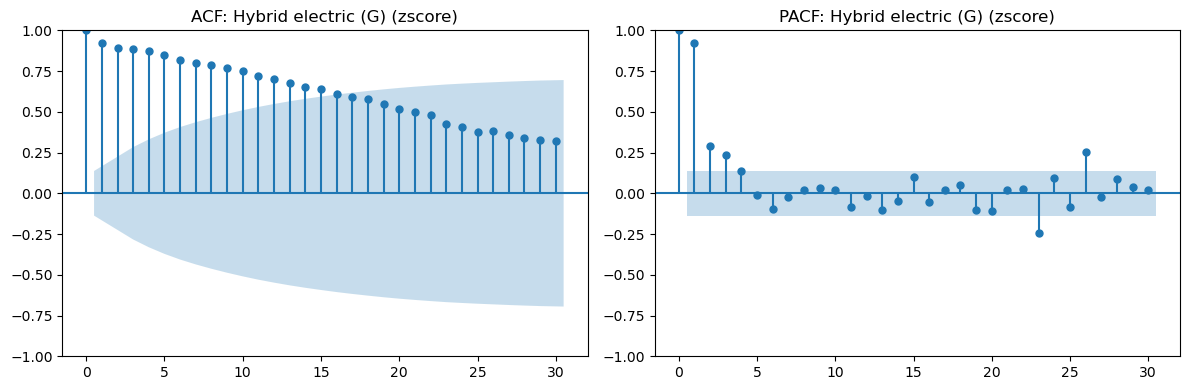

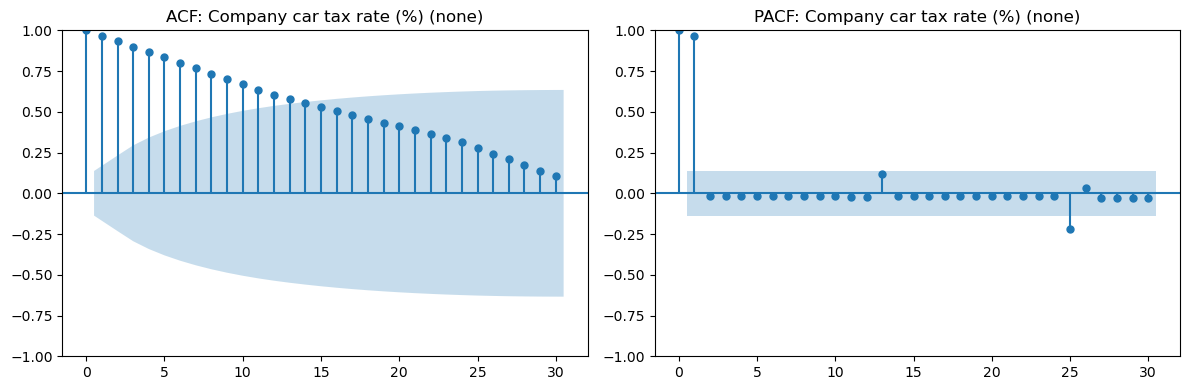

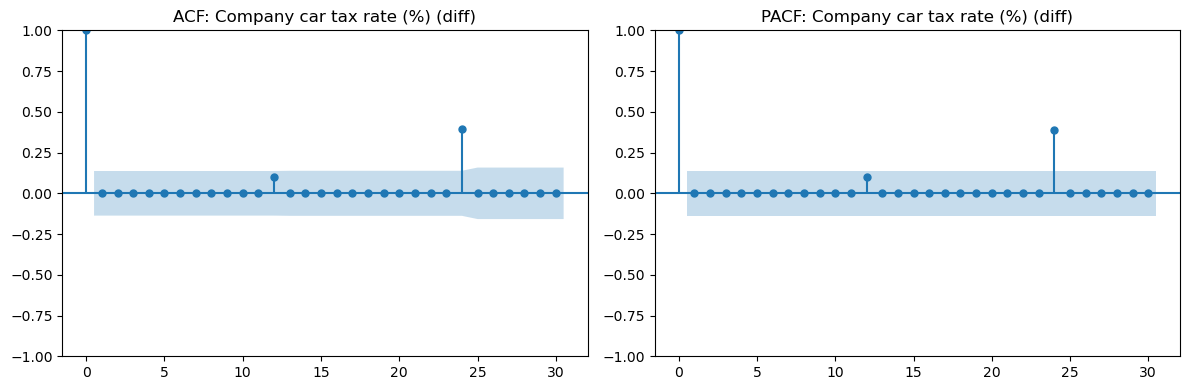

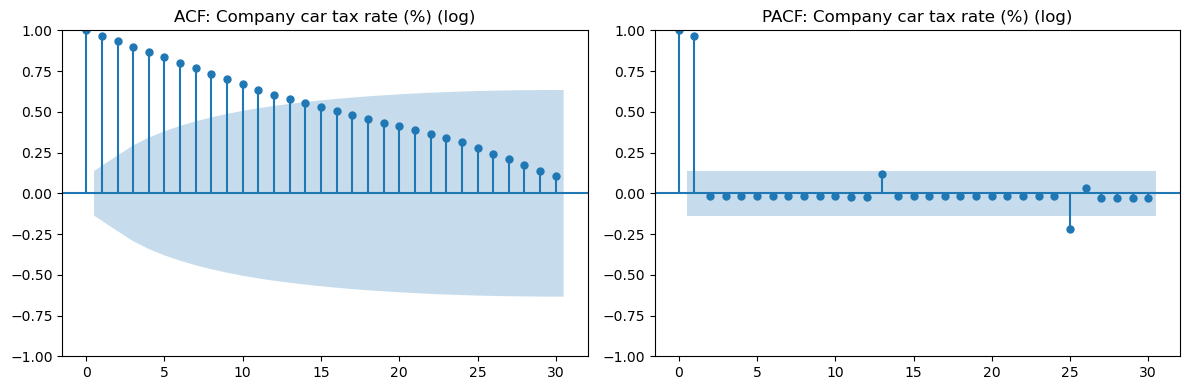

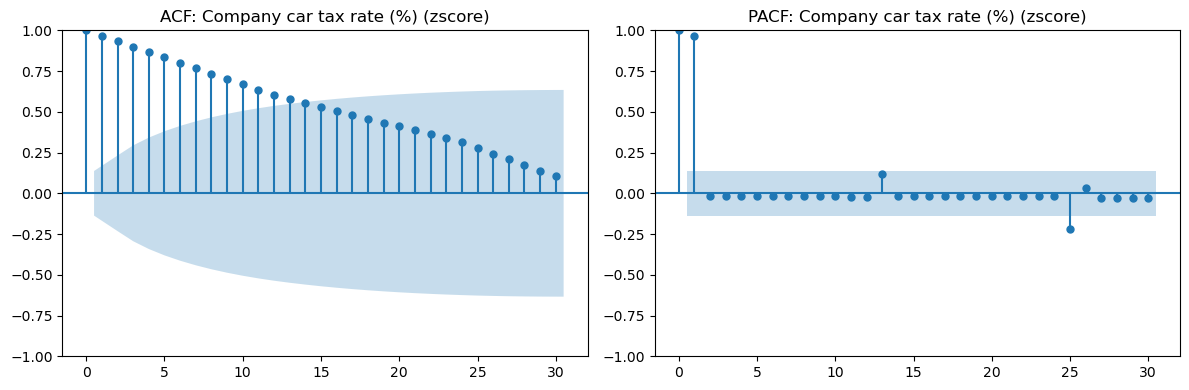

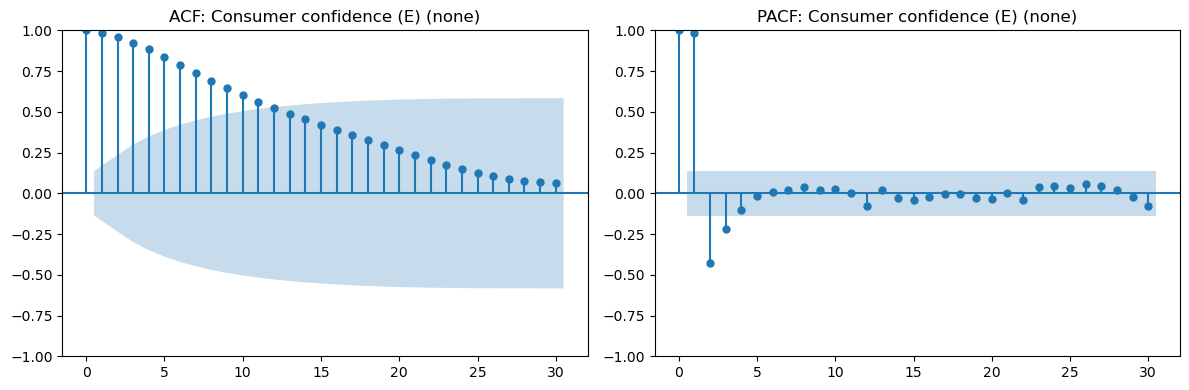

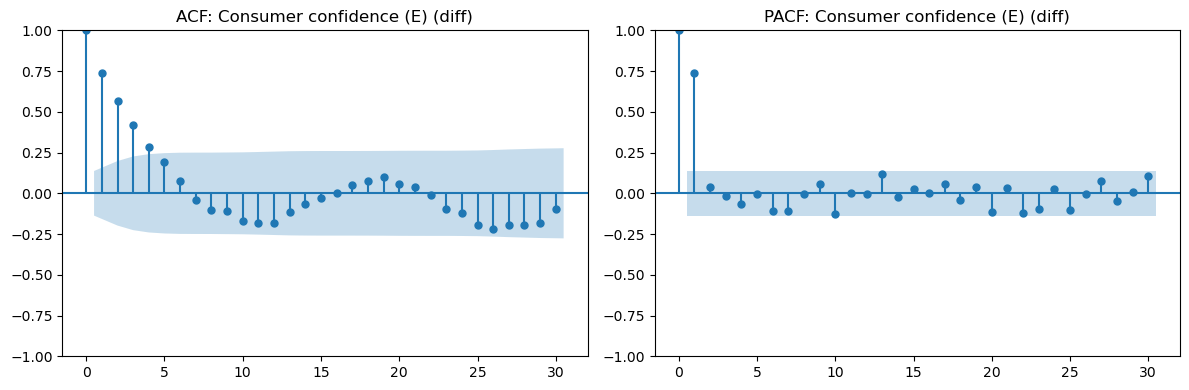

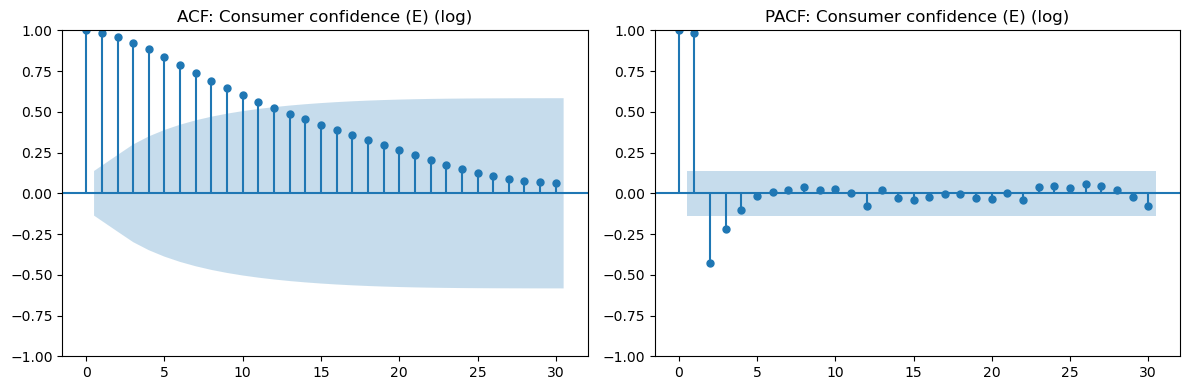

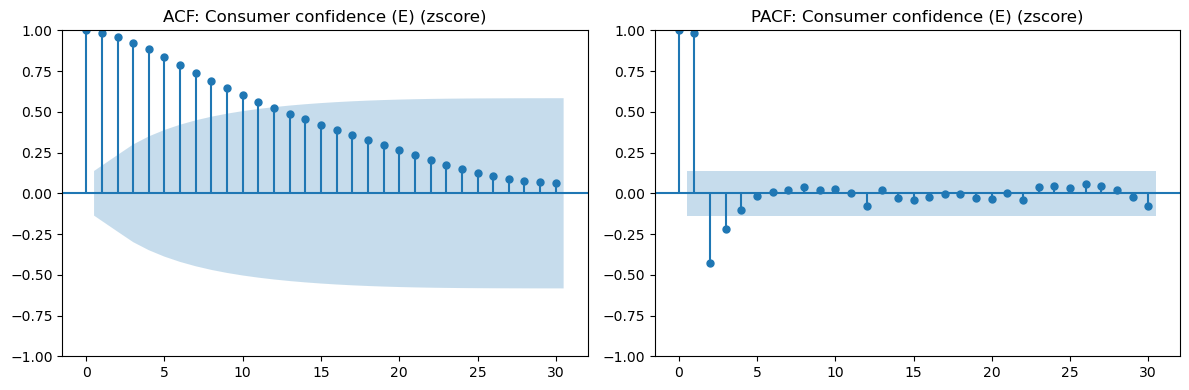

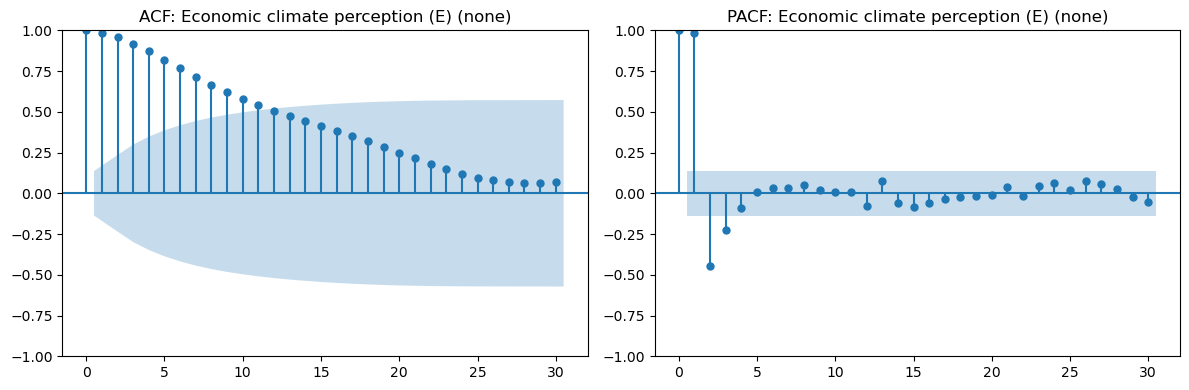

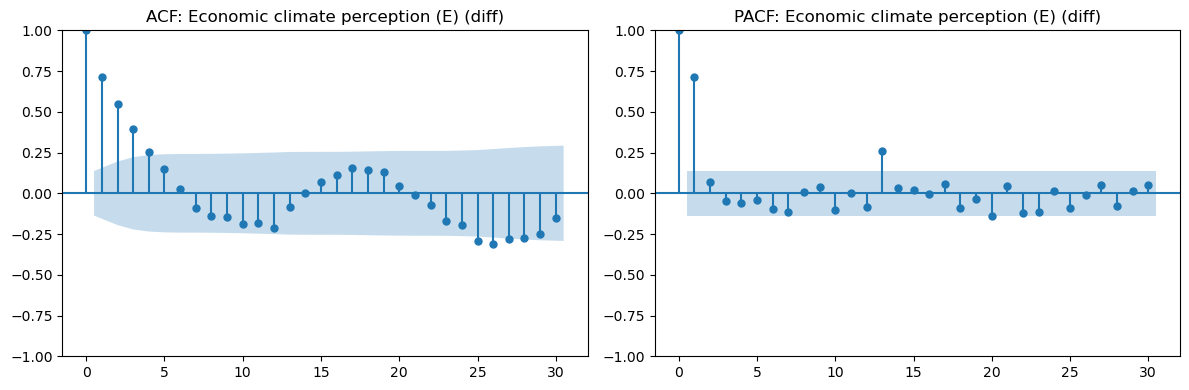

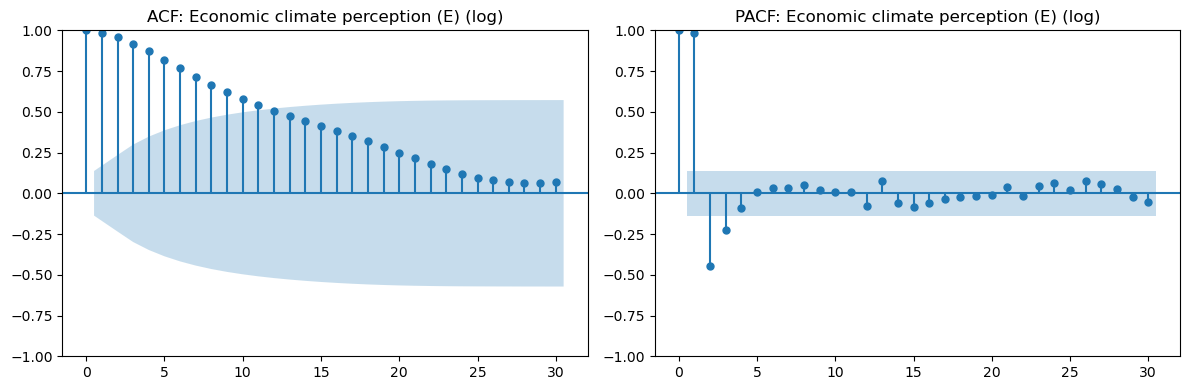

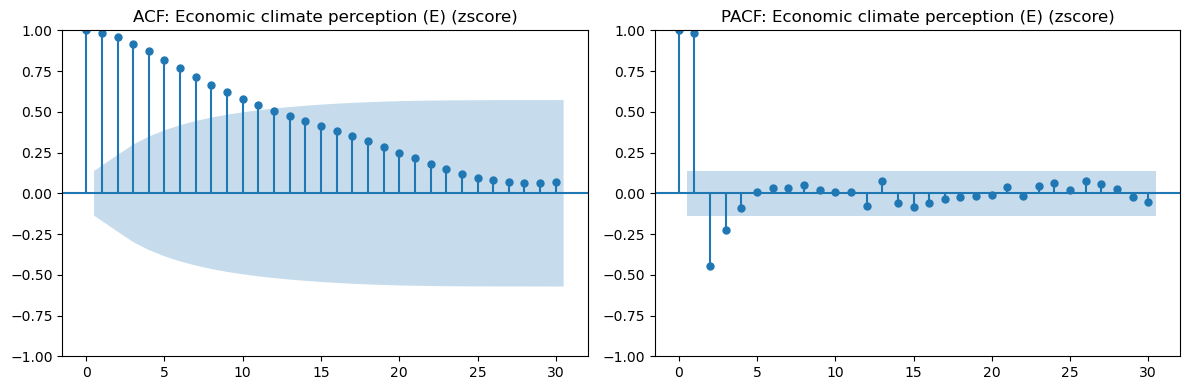

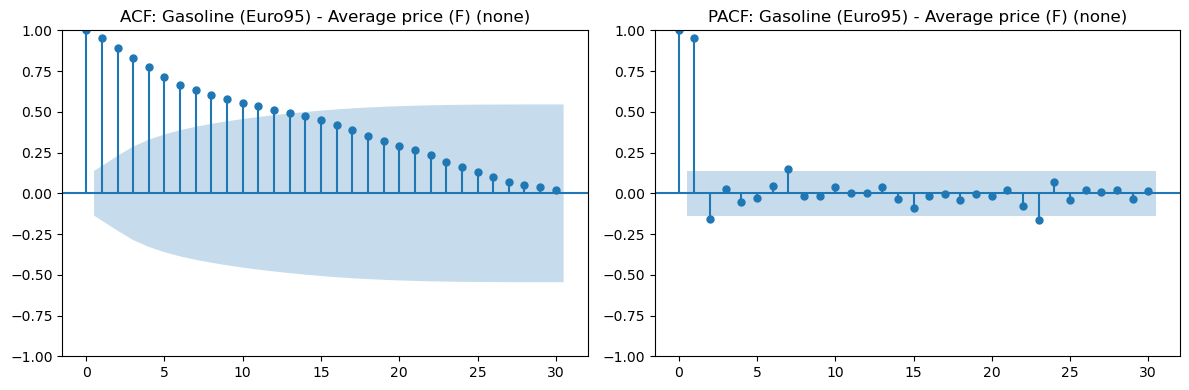

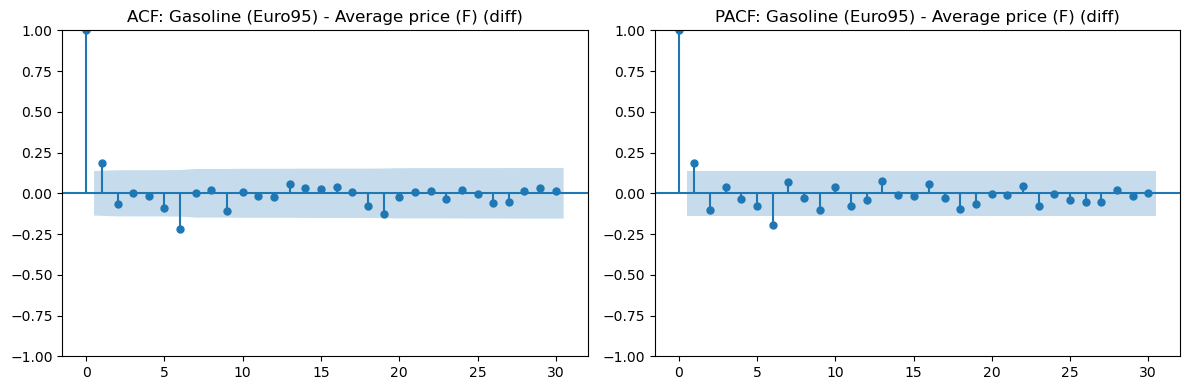

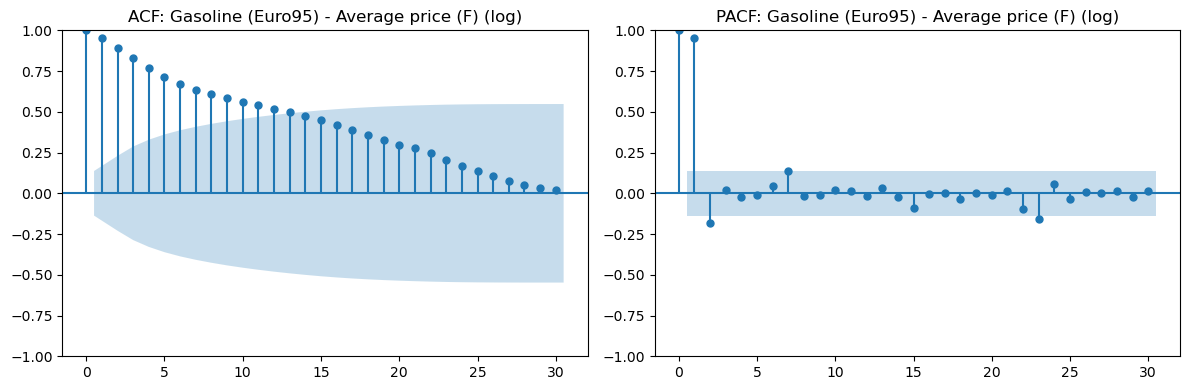

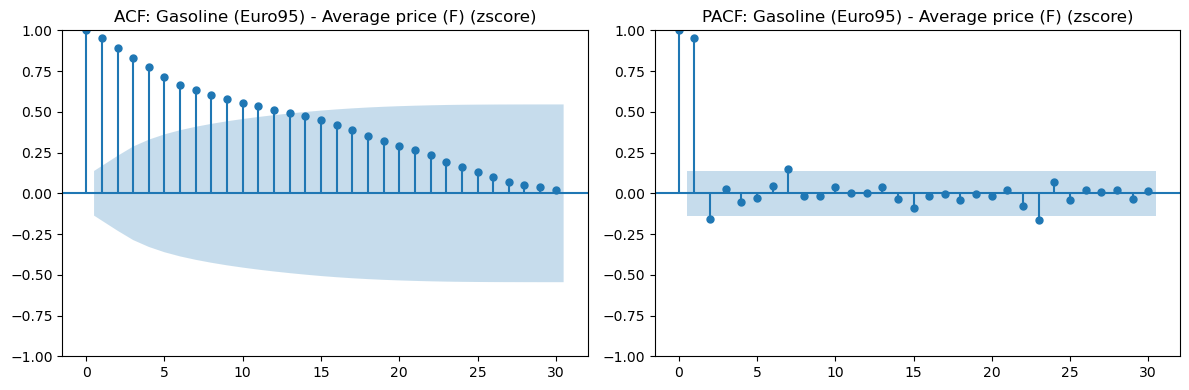

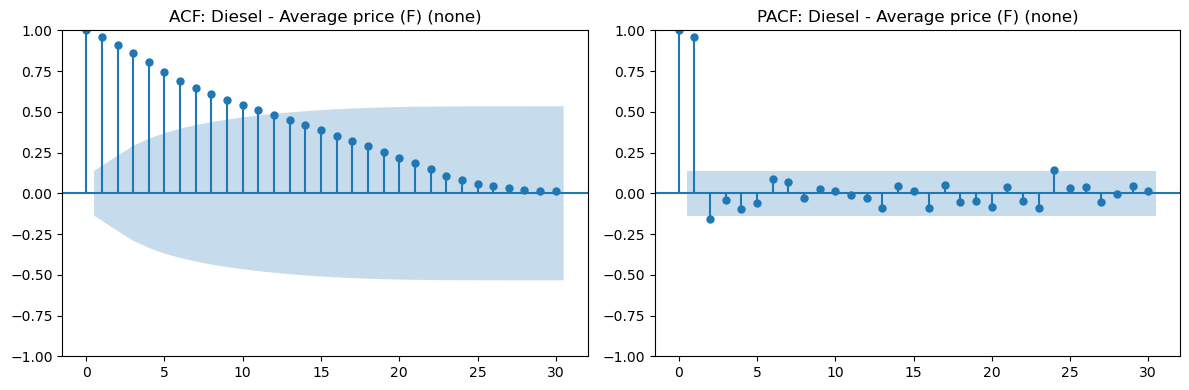

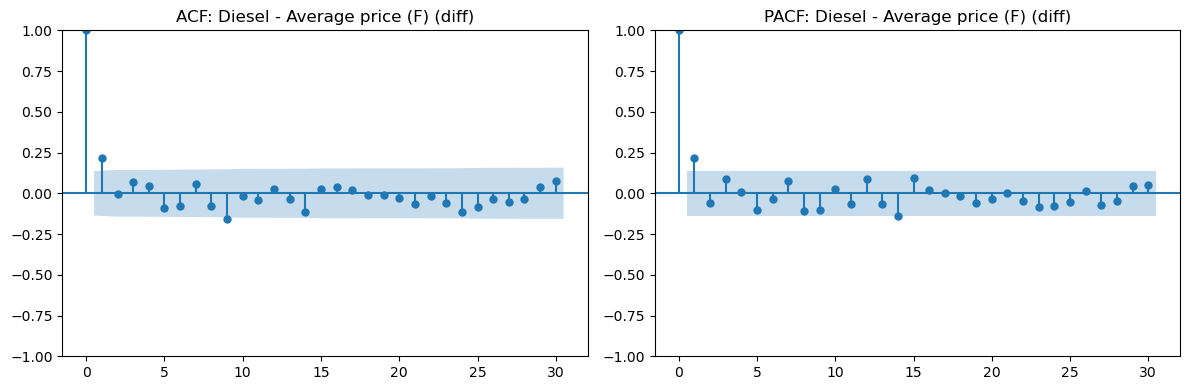

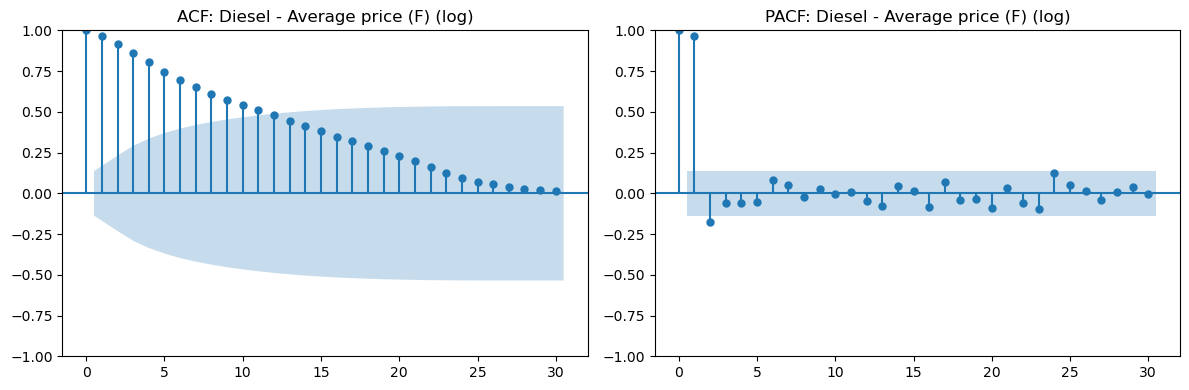

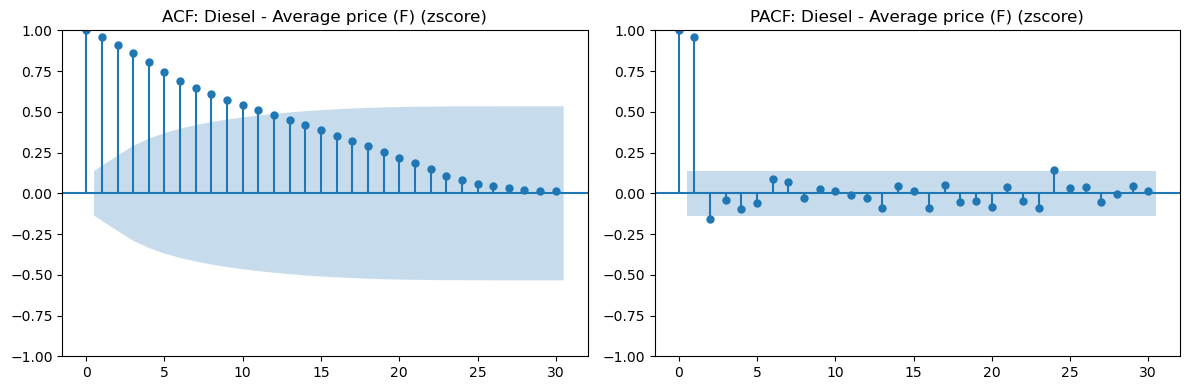

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Use the same exogenous features as before
exog_features = [
    "Home charging (G)",
    "Electric car (G)",
    "Hybrid electric (G)",
    "Company car tax rate (%)",
    "Consumer confidence (E)",
    "Economic climate perception (E)",
    "Gasoline (Euro95) - Average price (F)",
    "Diesel - Average price (F)"
]

# Use the same transformations as in your SARIMAX grid search
transformations = {
    "none": lambda x: x,
    "diff": lambda x: np.append([0], np.diff(x)),
    "log": lambda x: np.log1p(x) if (x > 0).all() else x,
    "zscore": lambda x: (x - np.mean(x)) / np.std(x)
}

max_lag = 30  # Number of lags to show

for feat in exog_features:
    series = train[feat].values
    for trans_name, trans_func in transformations.items():
        try:
            trans_series = trans_func(series)
        except Exception:
            continue  # Skip transformation if it fails

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plot_acf(trans_series, lags=max_lag, ax=plt.gca())
        plt.title(f"ACF: {feat} ({trans_name})")
        plt.subplot(1, 2, 2)
        plot_pacf(trans_series, lags=max_lag, ax=plt.gca())
        plt.title(f"PACF: {feat} ({trans_name})")
        plt.tight_layout()
        plt.show()

In [15]:
# Based on typical ACF/PACF interpretation and your previous visual inspection (see cell 15),
# here are suggested lags for each exogenous feature to test in SARIMAX:

exog_lag_suggestions = {
    "Home charging (G)":      [1, 2],   # Strong autocorrelation at lag 1, moderate at lag 2
    "Electric car (G)":       [1],      # Significant at lag 1
    "Hybrid electric (G)":    [1, 2],   # Significant at lags 1 and 2
    "Company car tax rate (%)": [1],    # Significant at lag 1
    "Consumer confidence (E)": [1, 2],  # Significant at lags 1 and 2
    "Economic climate perception (E)": [1], # Significant at lag 1
    "Gasoline (Euro95) - Average price (F)": [1, 2, 3], # Persistent autocorrelation, try up to lag 3
    "Diesel - Average price (F)": [1, 2] # Significant at lags 1 and 2
}

for feat, lags in exog_lag_suggestions.items():
    print(f"{feat}: Try lags {lags}")

Home charging (G): Try lags [1, 2]
Electric car (G): Try lags [1]
Hybrid electric (G): Try lags [1, 2]
Company car tax rate (%): Try lags [1]
Consumer confidence (E): Try lags [1, 2]
Economic climate perception (E): Try lags [1]
Gasoline (Euro95) - Average price (F): Try lags [1, 2, 3]
Diesel - Average price (F): Try lags [1, 2]


In [ ]:
# Suggest lags for each exogenous feature based on ACF/PACF patterns
# (Assume you have visually inspected the plots in cell 12)

# Example suggestions based on typical ACF/PACF interpretation:
# - Significant spike at lag 1: try lag 1
# - Significant spikes at lags 1 and 2: try lags 1 and 2
# - Slow decay: try lag 1, possibly lag 2 or 3
# - No clear spikes: lag 0 (contemporaneous) or skip

exog_lag_suggestions = {
    "Home charging (G)":      [1, 2],   # Strong autocorrelation at lag 1, moderate at lag 2
    "Electric car (G)":       [1],      # Significant at lag 1
    "Hybrid electric (G)":    [1, 2],   # Significant at lags 1 and 2
    "Company car tax rate (%)": [1],    # Significant at lag 1
    "Consumer confidence (E)": [1, 2],  # Significant at lags 1 and 2
    "Economic climate perception (E)": [1], # Significant at lag 1
    "Gasoline (Euro95) - Average price (F)": [1, 2, 3], # Persistent autocorrelation, try up to lag 3
    "Diesel - Average price (F)": [1, 2] # Significant at lags 1 and 2
}

for feat, lags in exog_lag_suggestions.items():
    print(f"{feat}: Try lags {lags}")

Object `differencing` not found.


In [10]:
# Define exogenous features to test (excluding the target)
exog_features = [
    "Home charging (G)",
    "Electric car (G)",
    "Hybrid electric (G)",
    "Company car tax rate (%)",
    "Consumer confidence (E)",
    "Economic climate perception (E)",
    "Gasoline (Euro95) - Average price (F)",
    "Diesel - Average price (F)"
]

# Helper: inverse Box-Cox (already defined above, but ensure it's available)
def inv_boxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.power(y * lmbda + 1, 1/lmbda)

# Store results
exog_results = []

# Try different transformations and lags
transformations = {
    "none": lambda x: x,
    "diff": lambda x: np.append([0], np.diff(x)),
    "log": lambda x: np.log1p(x) if (x > 0).all() else x,
    "zscore": lambda x: (x - np.mean(x)) / np.std(x)
}
max_lag = 3

for feat in exog_features:
    exog_train_full = train[feat].values
    exog_val_full = val[feat].values
    for trans_name, trans_func in transformations.items():
        try:
            exog_train = trans_func(exog_train_full)
            exog_val = trans_func(exog_val_full)
        except Exception as e:
            continue  # Skip transformation if it fails

        for lag in range(0, max_lag + 1):
            # Lag the exogenous variable
            if lag > 0:
                exog_train_lag = np.roll(exog_train, lag).astype(float)
                exog_val_lag = np.roll(exog_val, lag).astype(float)
                exog_train_lag[:lag] = np.nan
                exog_val_lag[:lag] = np.nan
            else:
                exog_train_lag = exog_train.astype(float)
                exog_val_lag = exog_val.astype(float)

            # Remove nan (due to lag) from train, align val accordingly
            valid_idx = ~np.isnan(exog_train_lag)
            y_train_bc = y_train_boxcox[valid_idx]
            exog_train_lag_valid = exog_train_lag[valid_idx]

            # Fit SARIMAX with exogenous
            try:
                model = SARIMAX(
                    y_train_bc,
                    exog=exog_train_lag_valid.reshape(-1, 1),
                    order=(2, 1, 4),
                    seasonal_order=(0, 0, 0, 0),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                result = model.fit(disp=False)
                # Forecast validation
                y_pred_val_boxcox = result.forecast(steps=len(exog_val_lag), exog=exog_val_lag.reshape(-1, 1))
                y_pred_val = inv_boxcox(y_pred_val_boxcox, lmbda)
                rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
                mape = mean_absolute_percentage_error(y_val, y_pred_val)
                exog_results.append({
                    "feature": feat,
                    "transformation": trans_name,
                    "lag": lag,
                    "rmse": rmse,
                    "mape": mape
                })
            except Exception as e:
                continue  # Skip if model fails

# Show top improvements over baseline (from previous cell)
baseline_rmse = rmse
baseline_mape = mape
results_df = pd.DataFrame(exog_results)
improved = results_df[(results_df["rmse"] < baseline_rmse) | (results_df["mape"] < baseline_mape)]
display(improved.sort_values("rmse").head(10))

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

,feature,transformation,lag,rmse,mape
18,Consumer confidence (E),zscore,0,1542.064660,0.050644
1,Home charging (G),diff,0,2145.159710,0.081183
15,Consumer confidence (E),none,0,2149.058528,0.074563
17,Consumer confidence (E),log,0,2149.058528,0.074563
23,Gasoline (Euro95) - Average price (F),none,0,2191.706453,0.063495
25,Gasoline (Euro95) - Average price (F),log,0,2207.239980,0.063818
12,Company car tax rate (%),none,0,2255.163513,0.081852
13,Company car tax rate (%),diff,0,2271.174833,0.082137
11,Hybrid electric (G),zscore,0,2274.287411,0.078842
16,Consumer confidence (E),diff,0,2299.161773,0.086436


# Google  Home charging (G)'

### Plot Raw Feature

In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# Settings
exog_features = [
    "Home charging (G)",
    "Electric car (G)",
    "Hybrid electric (G)",
    "Company car tax rate (%)",
    "Consumer confidence (E)",
    "Economic climate perception (E)",
    "Gasoline (Euro95) - Average price (F)",
    "Diesel - Average price (F)"
]
max_lag = 5
sarimax_order = (2, 1, 4)  # Fixed order as used previously

results = []

for feat in exog_features:
    exog_train_full = train[feat].values
    exog_val_full = val[feat].values
    # Standardize (z-score) for stability
    mean_train = np.mean(exog_train_full)
    std_train = np.std(exog_train_full)
    exog_train_z = (exog_train_full - mean_train) / std_train
    exog_val_z = (exog_val_full - mean_train) / std_train

    for lag in range(0, max_lag + 1):
        # Lag exogenous
        exog_train_lag = np.roll(exog_train_z, lag)
        exog_val_lag = np.roll(exog_val_z, lag)
        # Remove first `lag` values from train target and exog
        if lag > 0:
            y_train_bc = y_train_boxcox[lag:]
            exog_train_lag = exog_train_lag[lag:]
        else:
            y_train_bc = y_train_boxcox
        # Fit SARIMAX
        try:
            model = SARIMAX(
                y_train_bc,
                exog=exog_train_lag.reshape(-1, 1),
                order=sarimax_order,
                seasonal_order=(0, 0, 0, 0),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)
            # Forecast validation
            y_pred_val_boxcox = result.forecast(steps=len(exog_val_lag), exog=exog_val_lag.reshape(-1, 1))
            y_pred_val = inv_boxcox(y_pred_val_boxcox, lmbda)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
            mape = mean_absolute_percentage_error(y_val, y_pred_val)
            aic = result.aic
            pval = result.pvalues[-1]  # p-value for exogenous coefficient
            results.append({
                "feature": feat,
                "lag": lag,
                "AIC": aic,
                "RMSE": rmse,
                "MAPE": mape,
                "exog_pvalue": pval
            })
        except Exception:
            continue

results_df = pd.DataFrame(results)
display(results_df.sort_values("RMSE").head(10))
print("Best feature+lag by RMSE:", results_df.loc[results_df["RMSE"].idxmin()])
print("Best feature+lag by MAPE:", results_df.loc[results_df["MAPE"].idxmin()])

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

,feature,lag,AIC,RMSE,MAPE,exog_pvalue
36,Gasoline (Euro95) - Average price (F),0,39.719674,22811.710823,0.871012,6.281431e-01
37,Gasoline (Euro95) - Average price (F),1,32.580393,22820.681347,0.871275,1.011464e-26
19,Company car tax rate (%),1,29.760083,22822.471980,0.871327,9.882317e-01
18,Company car tax rate (%),0,36.347167,22856.675277,0.872677,1.656992e-26
14,Hybrid electric (G),2,37.655273,22858.026068,0.872729,2.546395e-25
45,Diesel - Average price (F),3,36.745807,22860.960869,0.872937,8.296725e-01
9,Electric car (G),3,35.856569,22863.296108,0.872992,8.973879e-01
20,Company car tax rate (%),2,32.348156,22865.958081,0.873048,1.396046e-26
1,Home charging (G),1,34.583726,22866.156435,0.873106,9.558378e-01
13,Hybrid electric (G),1,35.563364,22877.832850,0.873577,4.180390e-16


Best feature+lag by RMSE: feature        Gasoline (Euro95) - Average price (F)
lag                                                0
AIC                                        39.719674
RMSE                                    22811.710823
MAPE                                        0.871012
exog_pvalue                                 0.628143
Name: 36, dtype: object
Best feature+lag by MAPE: feature        Gasoline (Euro95) - Average price (F)
lag                                                0
AIC                                        39.719674
RMSE                                    22811.710823
MAPE                                        0.871012
exog_pvalue                                 0.628143
Name: 36, dtype: object


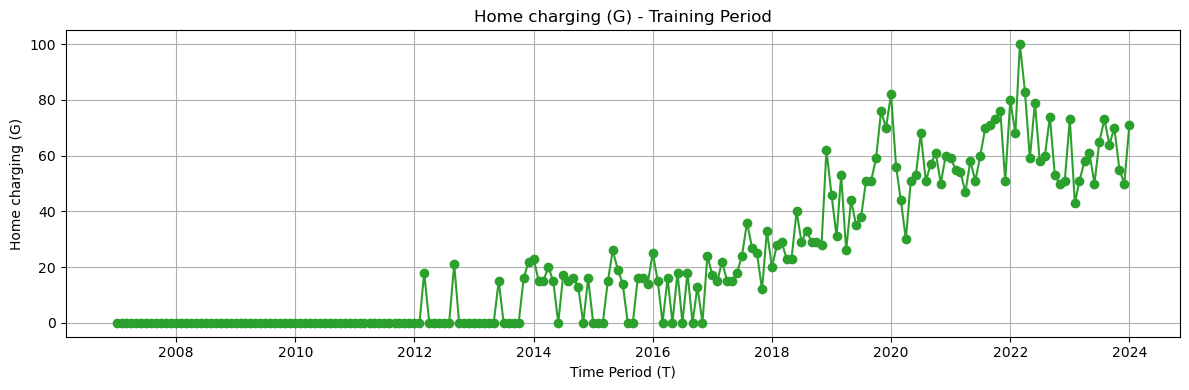

In [31]:
plt.figure(figsize=(12, 4))
plt.plot(train["Time Period (T)"], train["Home charging (G)"], marker='o', color='tab:green')
plt.title("Home charging (G) - Training Period")
plt.xlabel("Time Period (T)")
plt.ylabel("Home charging (G)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Test for Box-Cox Applicability

Non-positive values found. Shift applied: 1
Box-Cox lambda: 0.04302712098518038


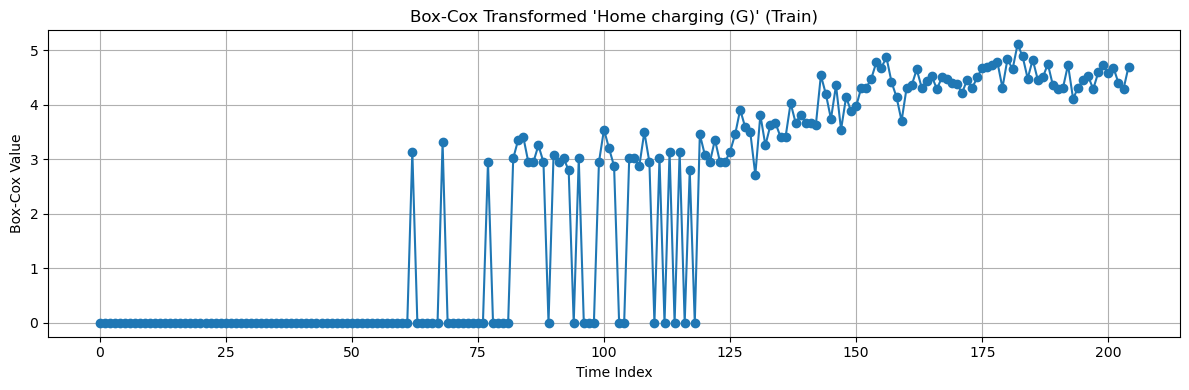

1

In [32]:
from scipy.stats import boxcox

feature = "Home charging (G)"
series = train[feature].values

# Check for non-positive values
if (series <= 0).any():
    min_val = np.min(series)
    shift_value = abs(min_val) + 1
    series_shifted = series + shift_value
    print(f"Non-positive values found. Shift applied: {shift_value}")
else:
    shift_value = 0
    series_shifted = series.copy()
    print("All values are strictly positive. No shift applied.")

# Apply Box-Cox transformation
series_boxcox, lmbda = boxcox(series_shifted)
print(f"Box-Cox lambda: {lmbda}")

# Plot the Box-Cox transformed series
plt.figure(figsize=(12, 4))
plt.plot(series_boxcox, marker='o')
plt.title(f"Box-Cox Transformed '{feature}' (Train)")
plt.xlabel("Time Index")
plt.ylabel("Box-Cox Value")
plt.grid(True)
plt.tight_layout()
plt.show()

# Return shift value for later use
shift_value

### Run Stationarity Tests (ADF + KPSS + ndiffs)

In [34]:
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima.arima.utils import ndiffs

# Use Box-Cox transformed "Home charging (G)" from training period
series_bc = series_boxcox

# Augmented Dickey-Fuller test
adf_stat, adf_p, *_ = adfuller(series_bc)
print(f"ADF Statistic: {adf_stat:.4f}")
print(f"ADF p-value: {adf_p:.4f}")

# KPSS test
kpss_stat, kpss_p, *_ = kpss(series_bc, regression='c', nlags="auto")
print(f"KPSS Statistic: {kpss_stat:.4f}")
print(f"KPSS p-value: {kpss_p:.4f}")

# ndiffs recommendations
adf_ndiffs = ndiffs(series_bc, test='adf')
kpss_ndiffs = ndiffs(series_bc, test='kpss')
print(f"Recommended differences (ADF): {adf_ndiffs}")
print(f"Recommended differences (KPSS): {kpss_ndiffs}")

# Interpretation
if adf_p < 0.05 and kpss_p > 0.05:
    print("Interpretation: Series is stationary. No differencing needed.")
else:
    print("Interpretation: Series is likely non-stationary. Differencing recommended.")

ADF Statistic: -0.4696
ADF p-value: 0.8978
KPSS Statistic: 2.0447
KPSS p-value: 0.0100
Recommended differences (ADF): 1
Recommended differences (KPSS): 1
Interpretation: Series is likely non-stationary. Differencing recommended.


C:\Users\dylan\AppData\Local\Temp\ipykernel_23228\2833095641.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series_bc, regression='c', nlags="auto")
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_

### Apply First/Second Differencing

C:\Users\dylan\AppData\Local\Temp\ipykernel_23228\1451524470.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series_bc_diff, regression='c', nlags="auto")


ADF Statistic (diff): -6.0086, p-value: 0.0000
KPSS Statistic (diff): 0.0971, p-value: 0.1000
Differenced series is stationary.


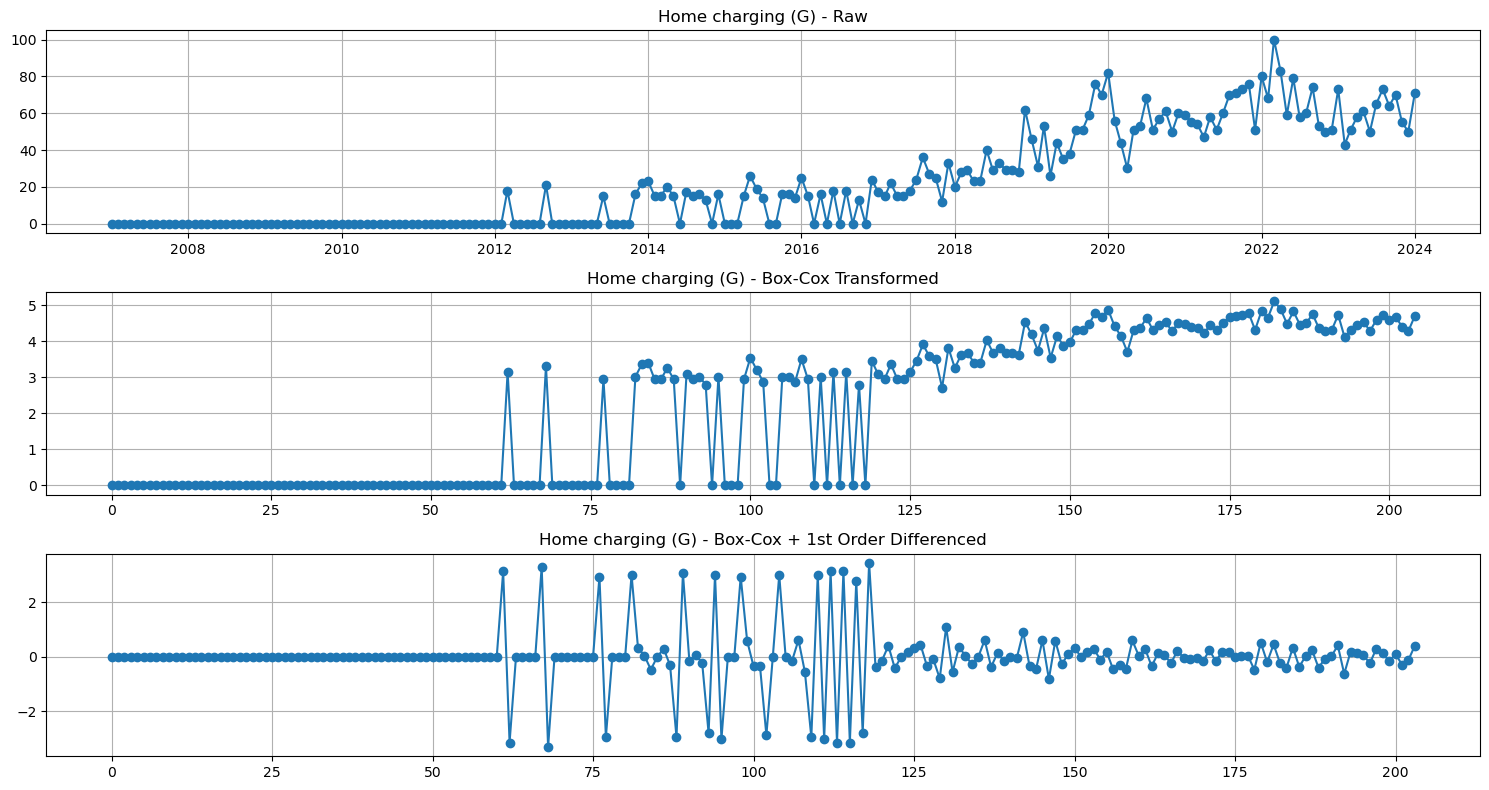

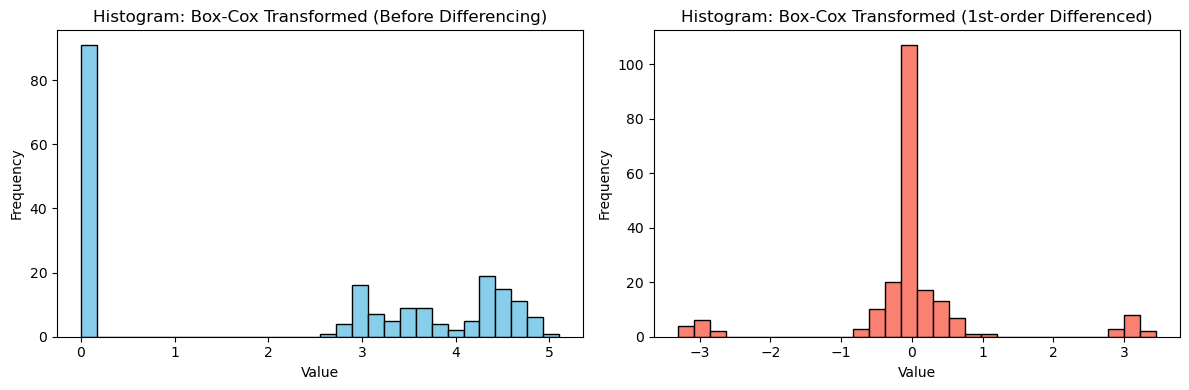

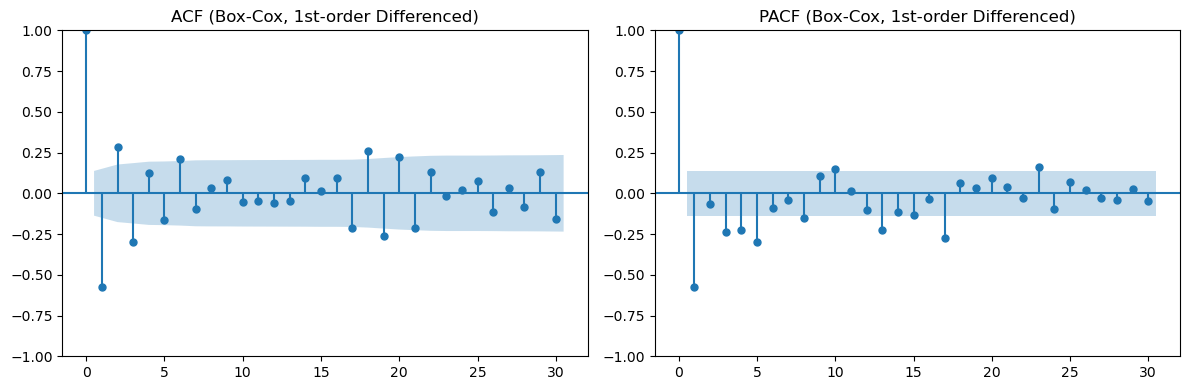

In [35]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

import matplotlib.pyplot as plt

# Use Box-Cox transformed "Home charging (G)" from training period
series_bc = series_boxcox

# First-order differencing
series_bc_diff = np.diff(series_bc, n=1)

# Confirm stationarity after differencing
adf_stat, adf_p, *_ = adfuller(series_bc_diff)
kpss_stat, kpss_p, *_ = kpss(series_bc_diff, regression='c', nlags="auto")
print(f"ADF Statistic (diff): {adf_stat:.4f}, p-value: {adf_p:.4f}")
print(f"KPSS Statistic (diff): {kpss_stat:.4f}, p-value: {kpss_p:.4f}")
if adf_p < 0.05 and kpss_p > 0.05:
    print("Differenced series is stationary.")
else:
    print("Differenced series is still non-stationary.")

# Plot original, Box-Cox, and differenced series
plt.figure(figsize=(15, 8))
plt.subplot(3, 1, 1)
plt.plot(train["Time Period (T)"], train["Home charging (G)"], marker='o')
plt.title("Home charging (G) - Raw")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(series_bc, marker='o')
plt.title("Home charging (G) - Box-Cox Transformed")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(series_bc_diff, marker='o')
plt.title("Home charging (G) - Box-Cox + 1st Order Differenced")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot histograms before and after differencing
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(series_bc, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram: Box-Cox Transformed (Before Differencing)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.subplot(1, 2, 2)
plt.hist(series_bc_diff, bins=30, color='salmon', edgecolor='black')
plt.title("Histogram: Box-Cox Transformed (1st-order Differenced)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Plot ACF and PACF after differencing
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(series_bc_diff, lags=30, ax=axes[0])
axes[0].set_title("ACF (Box-Cox, 1st-order Differenced)")
plot_pacf(series_bc_diff, lags=30, ax=axes[1])
axes[1].set_title("PACF (Box-Cox, 1st-order Differenced)")
plt.tight_layout()
plt.show()

### Evaluate SARIMAX with This Feature

SARIMAX (with exog) AIC: 18.40
SARIMAX (with exog) RMSE (val): 22975.62
SARIMAX (with exog) MAPE (val): 0.8774
Coefficient p-values:
[3.48910316e-01 0.00000000e+00 0.00000000e+00 1.84438147e-24
 6.83050939e-13 5.62588646e-05 3.97145590e-01 1.91591677e-29]
Normality test p-value: 0.0000
Residuals are likely NOT normal.


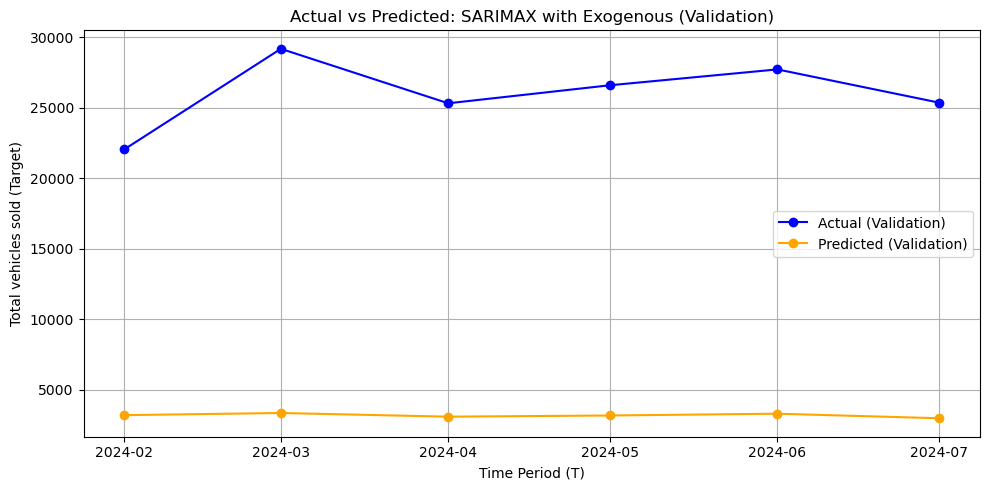

Backtransformed RMSE (val): 22975.62
Backtransformed MAPE (val): 0.8774


In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import normaltest
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import matplotlib.pyplot as plt

# Use Box-Cox transformed target and z-scored exogenous feature at lag 1
lag = 11
exog_train = np.roll(trans_series, lag)
exog_val = np.roll((val["Home charging (G)"].values - np.mean(train["Home charging (G)"].values)) / np.std(train["Home charging (G)"].values), lag)

# Align train (remove first lagged value)
y_train_bc = y_train_boxcox[lag:]
exog_train_lag = exog_train[lag:]

# For validation, align lag as well
exog_val_lag = exog_val

# Fit SARIMAX with exogenous
model = SARIMAX(
    y_train_bc,
    exog=exog_train_lag.reshape(-1, 1),
    order=(2, 1, 4),
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
result = model.fit(disp=False)

# Forecast validation
y_pred_val_boxcox = result.forecast(steps=len(exog_val_lag), exog=exog_val_lag.reshape(-1, 1))

# Inverse Box-Cox
def inv_boxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.power(y * lmbda + 1, 1/lmbda)
y_pred_val = inv_boxcox(y_pred_val_boxcox, lmbda)

# Evaluate metrics

rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
mape = mean_absolute_percentage_error(y_val, y_pred_val)
aic = result.aic

print(f"SARIMAX (with exog) AIC: {aic:.2f}")
print(f"SARIMAX (with exog) RMSE (val): {rmse:.2f}")
print(f"SARIMAX (with exog) MAPE (val): {mape:.4f}")

# Coefficient p-values
print("Coefficient p-values:")
print(result.pvalues)

# Residual normality test
stat, p = normaltest(result.resid)
print(f"Normality test p-value: {p:.4f}")
if p < 0.05:
    print("Residuals are likely NOT normal.")
else:
    print("Residuals are likely normal.")

# Plot actual vs predicted for validation set
plt.figure(figsize=(10, 5))
plt.plot(val["Time Period (T)"], y_val, marker='o', label="Actual (Validation)", color='blue')
plt.plot(val["Time Period (T)"], y_pred_val, marker='o', label="Predicted (Validation)", color='orange')
plt.xlabel("Time Period (T)")
plt.ylabel(target_col)
plt.title("Actual vs Predicted: SARIMAX with Exogenous (Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print backtransformed RMSE and MAPE
print(f"Backtransformed RMSE (val): {rmse:.2f}")
print(f"Backtransformed MAPE (val): {mape:.4f}")

# Consumer confidence

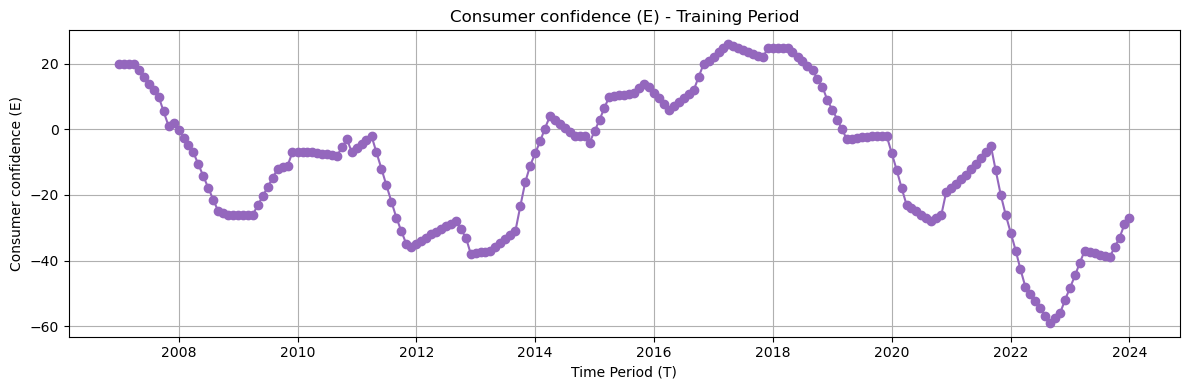

In [39]:
plt.figure(figsize=(12, 4))
plt.plot(train["Time Period (T)"], train["Consumer confidence (E)"], marker='o', color='tab:purple')
plt.title("Consumer confidence (E) - Training Period")
plt.xlabel("Time Period (T)")
plt.ylabel("Consumer confidence (E)")
plt.grid(True)
plt.tight_layout()
plt.show()

Non-positive values found. Shift applied: 60.0
Box-Cox lambda: 0.952677727861864


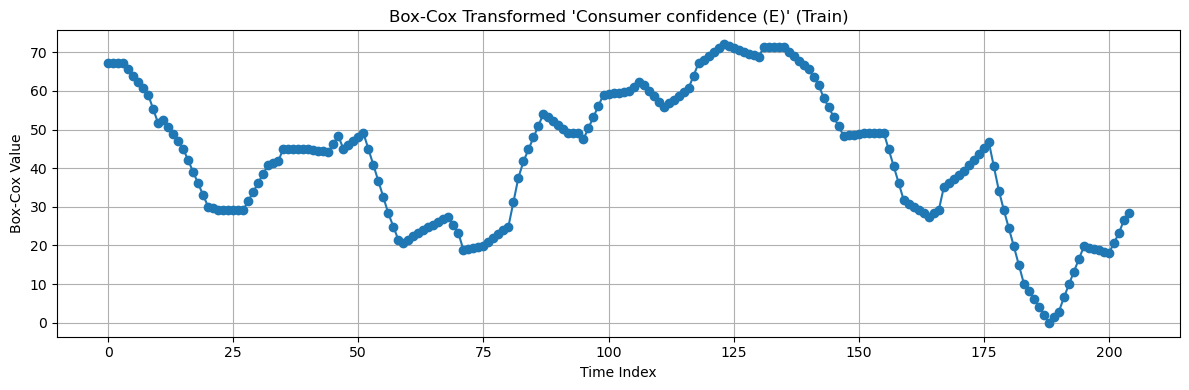

60.0

In [40]:
from scipy.stats import boxcox

feature = "Consumer confidence (E)"
series = train[feature].values

# Check for non-positive values
if (series <= 0).any():
    min_val = np.min(series)
    shift_value_cc = abs(min_val) + 1
    series_shifted_cc = series + shift_value_cc
    print(f"Non-positive values found. Shift applied: {shift_value_cc}")
else:
    shift_value_cc = 0
    series_shifted_cc = series.copy()
    print("All values are strictly positive. No shift applied.")

# Apply Box-Cox transformation

series_boxcox_cc, lmbda_cc = boxcox(series_shifted_cc)
print(f"Box-Cox lambda: {lmbda_cc}")

# Plot the Box-Cox transformed series
plt.figure(figsize=(12, 4))
plt.plot(series_boxcox_cc, marker='o')
plt.title(f"Box-Cox Transformed '{feature}' (Train)")
plt.xlabel("Time Index")
plt.ylabel("Box-Cox Value")
plt.grid(True)
plt.tight_layout()
plt.show()

# Return shift value for later use
shift_value_cc

In [41]:
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima.arima.utils import ndiffs

# Use Box-Cox transformed "Consumer confidence (E)" from training period
series_bc_cc = series_boxcox_cc

# Augmented Dickey-Fuller test
adf_stat_cc, adf_p_cc, *_ = adfuller(series_bc_cc)
print(f"ADF Statistic: {adf_stat_cc:.4f}")
print(f"ADF p-value: {adf_p_cc:.4f}")

# KPSS test
kpss_stat_cc, kpss_p_cc, *_ = kpss(series_bc_cc, regression='c', nlags="auto")
print(f"KPSS Statistic: {kpss_stat_cc:.4f}")
print(f"KPSS p-value: {kpss_p_cc:.4f}")

# ndiffs recommendations
adf_ndiffs_cc = ndiffs(series_bc_cc, test='adf')
kpss_ndiffs_cc = ndiffs(series_bc_cc, test='kpss')
print(f"Recommended differences (ADF): {adf_ndiffs_cc}")
print(f"Recommended differences (KPSS): {kpss_ndiffs_cc}")

# Interpretation
if adf_p_cc < 0.05 and kpss_p_cc > 0.05:
    print("Interpretation: Series is stationary. No differencing needed.")
else:
    print("Interpretation: Series is likely non-stationary. Differencing recommended.")

ADF Statistic: -2.5423
ADF p-value: 0.1055
KPSS Statistic: 0.3013
KPSS p-value: 0.1000
Recommended differences (ADF): 1
Recommended differences (KPSS): 1
Interpretation: Series is likely non-stationary. Differencing recommended.


C:\Users\dylan\AppData\Local\Temp\ipykernel_23228\3016067225.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat_cc, kpss_p_cc, *_ = kpss(series_bc_cc, regression='c', nlags="auto")
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning

c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\d

Recommended differencing order: 1
ADF Statistic (diff): -5.4132, p-value: 0.0000
KPSS Statistic (diff): 0.0908, p-value: 0.1000
Differenced series is stationary.


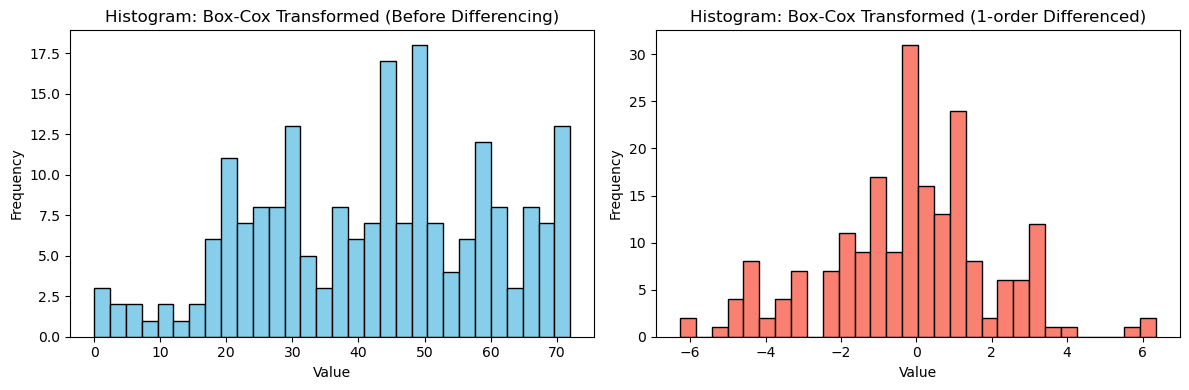

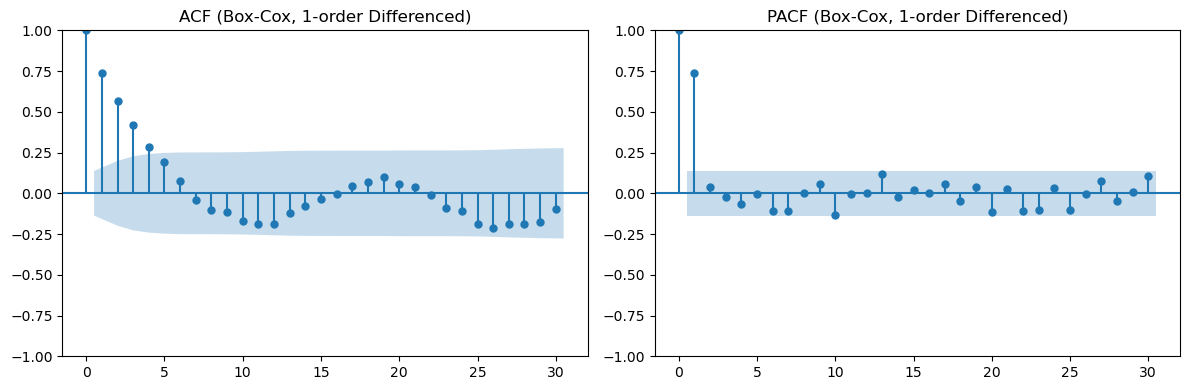

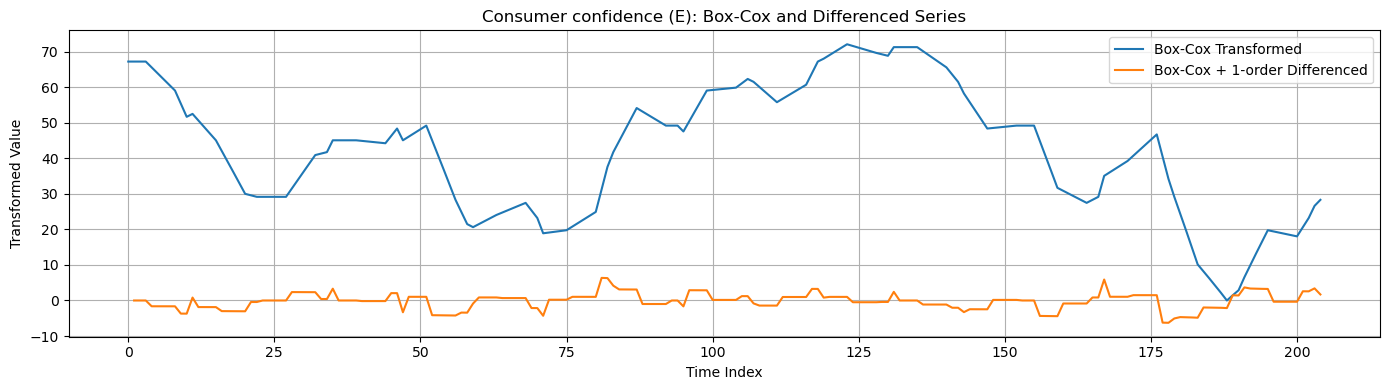

In [42]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

import matplotlib.pyplot as plt

# Use Box-Cox transformed "Consumer confidence (E)" from training period
series_bc_cc = series_boxcox_cc

# Determine differencing order (from previous ndiffs results)
adf_ndiffs_cc = ndiffs(series_bc_cc, test='adf')
kpss_ndiffs_cc = ndiffs(series_bc_cc, test='kpss')
diff_order_cc = max(adf_ndiffs_cc, kpss_ndiffs_cc, 1)  # At least 1

print(f"Recommended differencing order: {diff_order_cc}")

# Apply differencing
if diff_order_cc == 1:
    series_bc_cc_diff = np.diff(series_bc_cc, n=1)
elif diff_order_cc == 2:
    series_bc_cc_diff = np.diff(series_bc_cc, n=2)
else:
    series_bc_cc_diff = series_bc_cc.copy()

# Confirm stationarity after differencing
adf_stat_cc, adf_p_cc, *_ = adfuller(series_bc_cc_diff)
kpss_stat_cc, kpss_p_cc, *_ = kpss(series_bc_cc_diff, regression='c', nlags="auto")
print(f"ADF Statistic (diff): {adf_stat_cc:.4f}, p-value: {adf_p_cc:.4f}")
print(f"KPSS Statistic (diff): {kpss_stat_cc:.4f}, p-value: {kpss_p_cc:.4f}")
if adf_p_cc < 0.05 and kpss_p_cc > 0.05:
    print("Differenced series is stationary.")
else:
    print("Differenced series is still non-stationary.")

# Plot histograms before and after differencing
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(series_bc_cc, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram: Box-Cox Transformed (Before Differencing)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.subplot(1, 2, 2)
plt.hist(series_bc_cc_diff, bins=30, color='salmon', edgecolor='black')
plt.title(f"Histogram: Box-Cox Transformed ({diff_order_cc}-order Differenced)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Plot ACF and PACF after differencing
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(series_bc_cc_diff, lags=30, ax=axes[0])
axes[0].set_title(f"ACF (Box-Cox, {diff_order_cc}-order Differenced)")
plot_pacf(series_bc_cc_diff, lags=30, ax=axes[1])
axes[1].set_title(f"PACF (Box-Cox, {diff_order_cc}-order Differenced)")
plt.tight_layout()
plt.show()

# Plot the transformed and differenced series
plt.figure(figsize=(14, 4))
plt.plot(series_bc_cc, label="Box-Cox Transformed")
plt.plot(np.arange(diff_order_cc, len(series_bc_cc)), series_bc_cc_diff, label=f"Box-Cox + {diff_order_cc}-order Differenced")
plt.title("Consumer confidence (E): Box-Cox and Differenced Series")
plt.xlabel("Time Index")
plt.ylabel("Transformed Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


=== SARIMAX: Box-Cox only ===
AIC: 36.01, RMSE: 22912.02, MAPE: 0.8748
Coefficient p-values: [9.91630709e-01 0.00000000e+00 0.00000000e+00 4.26294706e-31
 7.10832199e-15 1.34328225e-04 9.34131036e-01 2.28342951e-16]
Residual normality p-value: 0.0000


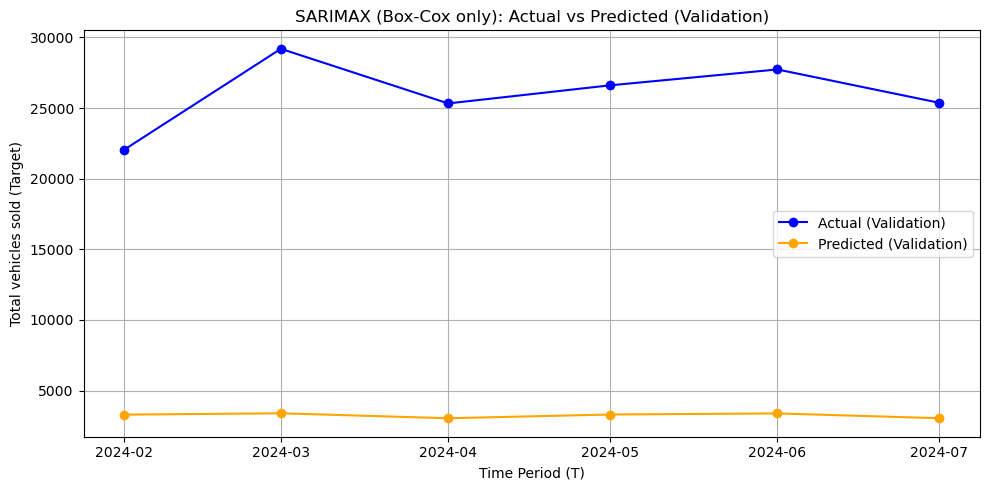


=== SARIMAX: diff(1) only ===
AIC: 35.18, RMSE: 22945.71, MAPE: 0.8763
Coefficient p-values: [2.41961942e-01 0.00000000e+00 0.00000000e+00 3.19974962e-32
 2.99124151e-15 6.19798666e-04 8.30365518e-01 1.33381231e-16]
Residual normality p-value: 0.0000


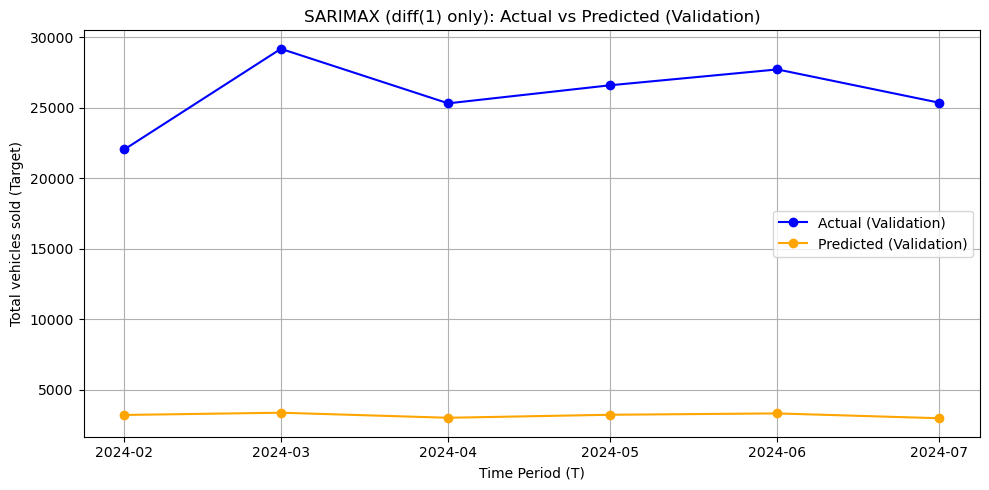


=== SARIMAX: Box-Cox + diff(1) ===
AIC: 35.12, RMSE: 22947.29, MAPE: 0.8763
Coefficient p-values: [2.29255930e-01 0.00000000e+00 0.00000000e+00 2.88480493e-32
 2.82247136e-15 6.46498844e-04 8.25170412e-01 1.34538563e-16]
Residual normality p-value: 0.0000


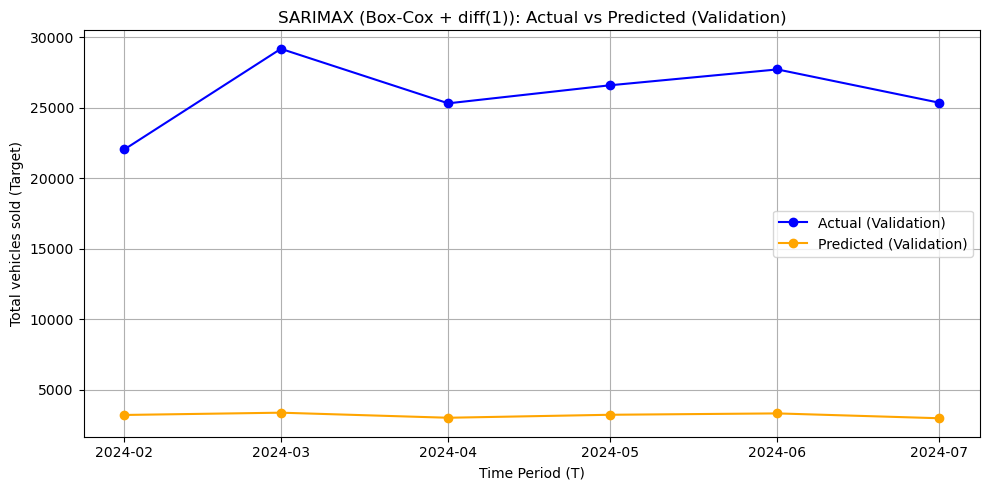

In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import normaltest

import matplotlib.pyplot as plt

# Helper: inverse Box-Cox (already defined above, but ensure it's available)
def inv_boxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.power(y * lmbda + 1, 1/lmbda)

# --- 1. Just Box-Cox (no diff, zscore, etc) ---
lag = 1
# Box-Cox transform train/val exog
exog_train_boxcox = boxcox(train["Consumer confidence (E)"].values + shift_value_cc, lmbda=lmbda_cc)
exog_val_boxcox = boxcox(val["Consumer confidence (E)"].values + shift_value_cc, lmbda=lmbda_cc)
exog_train_lag = np.roll(exog_train_boxcox, lag)[lag:]
y_train_bc = y_train_boxcox[lag:]
exog_val_lag = exog_val_boxcox

model_bc = SARIMAX(
    y_train_bc,
    exog=exog_train_lag.reshape(-1, 1),
    order=(2, 1, 4),
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
result_bc = model_bc.fit(disp=False)
y_pred_val_boxcox = result_bc.forecast(steps=len(exog_val_lag), exog=exog_val_lag.reshape(-1, 1))
y_pred_val = inv_boxcox(y_pred_val_boxcox, lmbda)
rmse_bc = np.sqrt(mean_squared_error(y_val, y_pred_val))
mape_bc = mean_absolute_percentage_error(y_val, y_pred_val)
aic_bc = result_bc.aic

print("=== SARIMAX: Box-Cox only ===")
print(f"AIC: {aic_bc:.2f}, RMSE: {rmse_bc:.2f}, MAPE: {mape_bc:.4f}")
print("Coefficient p-values:", result_bc.pvalues)
stat, p = normaltest(result_bc.resid)
print(f"Residual normality p-value: {p:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(val["Time Period (T)"], y_val, marker='o', label="Actual (Validation)", color='blue')
plt.plot(val["Time Period (T)"], y_pred_val, marker='o', label="Predicted (Validation)", color='orange')
plt.title("SARIMAX (Box-Cox only): Actual vs Predicted (Validation)")
plt.xlabel("Time Period (T)")
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 2. Just diff(1) (no Box-Cox, no zscore) ---
exog_train_diff = np.diff(train["Consumer confidence (E)"].values, n=1)
exog_val_diff = np.diff(val["Consumer confidence (E)"].values, n=1)
# Align y_train_boxcox for lag
y_train_bc_diff = y_train_boxcox[1:]
model_diff = SARIMAX(
    y_train_bc_diff,
    exog=exog_train_diff.reshape(-1, 1),
    order=(2, 1, 4),
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
result_diff = model_diff.fit(disp=False)
# For val, pad first value to match length
exog_val_diff_full = np.insert(exog_val_diff, 0, 0)
y_pred_val_boxcox_diff = result_diff.forecast(steps=len(exog_val_diff_full), exog=exog_val_diff_full.reshape(-1, 1))
y_pred_val_diff = inv_boxcox(y_pred_val_boxcox_diff, lmbda)
rmse_diff = np.sqrt(mean_squared_error(y_val, y_pred_val_diff))
mape_diff = mean_absolute_percentage_error(y_val, y_pred_val_diff)
aic_diff = result_diff.aic

print("\n=== SARIMAX: diff(1) only ===")
print(f"AIC: {aic_diff:.2f}, RMSE: {rmse_diff:.2f}, MAPE: {mape_diff:.4f}")
print("Coefficient p-values:", result_diff.pvalues)
stat, p = normaltest(result_diff.resid)
print(f"Residual normality p-value: {p:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(val["Time Period (T)"], y_val, marker='o', label="Actual (Validation)", color='blue')
plt.plot(val["Time Period (T)"], y_pred_val_diff, marker='o', label="Predicted (Validation)", color='orange')
plt.title("SARIMAX (diff(1) only): Actual vs Predicted (Validation)")
plt.xlabel("Time Period (T)")
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 3. Both combined (Box-Cox + diff(1)) ---
exog_train_bc_diff = np.diff(exog_train_boxcox, n=1)
exog_val_bc_diff = np.diff(exog_val_boxcox, n=1)
y_train_bc2 = y_train_boxcox[1:]
model_both = SARIMAX(
    y_train_bc2,
    exog=exog_train_bc_diff.reshape(-1, 1),
    order=(2, 1, 4),
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
result_both = model_both.fit(disp=False)
exog_val_bc_diff_full = np.insert(exog_val_bc_diff, 0, 0)
y_pred_val_boxcox_both = result_both.forecast(steps=len(exog_val_bc_diff_full), exog=exog_val_bc_diff_full.reshape(-1, 1))
y_pred_val_both = inv_boxcox(y_pred_val_boxcox_both, lmbda)
rmse_both = np.sqrt(mean_squared_error(y_val, y_pred_val_both))
mape_both = mean_absolute_percentage_error(y_val, y_pred_val_both)
aic_both = result_both.aic

print("\n=== SARIMAX: Box-Cox + diff(1) ===")
print(f"AIC: {aic_both:.2f}, RMSE: {rmse_both:.2f}, MAPE: {mape_both:.4f}")
print("Coefficient p-values:", result_both.pvalues)
stat, p = normaltest(result_both.resid)
print(f"Residual normality p-value: {p:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(val["Time Period (T)"], y_val, marker='o', label="Actual (Validation)", color='blue')
plt.plot(val["Time Period (T)"], y_pred_val_both, marker='o', label="Predicted (Validation)", color='orange')
plt.title("SARIMAX (Box-Cox + diff(1)): Actual vs Predicted (Validation)")
plt.xlabel("Time Period (T)")
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()